In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, hessian
import matplotlib.pyplot as plt

In [2]:


# training all layers
def action_full_direct_integral(order_params, eta, gamma):
    H1, H2, G1, G2, A, B, Delta, hat_H1, hat_H2, hat_G1, hat_G2, hat_Delta = order_params # note that A , B are their own duals
    trace_term = 0.5*(jnp.sum(H1 * hat_H1) + jnp.sum(H2 * hat_H2) + jnp.sum(G1 * hat_G1) +jnp.sum(G2 *hat_G2) ) - gamma**2 * jnp.trace( A @ B )  
    
    # need a quick way to compute the constraints for H1, H2, G1, G2
    # h1 = u^1 + gamma C^1 g^1 , C^1 = Theta_Delta
    # g1 = r^1 + gamma D^1 h^1 , D^1 = 
    T = Delta.shape[0]
    eps = 1e-6
    
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_Delt = eta * jnp.einsum('ij,j->ij', Theta, Delta)
    C1 = gamma * Theta_Delt 
    D1 = gamma * ( Theta_Delt * G2 +  B )
    C2 = gamma * ( Theta_Delt * H1 +  A )
    D2 = gamma * Theta_Delt
    
    # first layer: 
    Sigma_u = jnp.ones((T,T))
    Sigma_r = G2
    
    row1 = jnp.concatenate([-hat_H1, jnp.zeros((T,T)), jnp.eye(T), -D1.T], axis = 1)
    row2 = jnp.concatenate([jnp.zeros((T,T)), -hat_G1, -C1.T, jnp.eye(T)], axis = 1)
    row3 = jnp.concatenate([jnp.eye(T), - C1, Sigma_u, jnp.zeros((T,T))], axis = 1)
    row4 = jnp.concatenate([-D1, jnp.eye(T), jnp.zeros((T,T)), Sigma_r], axis = 1)
    block_full = jnp.concatenate([row1, row2, row3, row4], axis = 0)
    _, logdet1 = jnp.linalg.slogdet(block_full)
    
    # second layer
    Sigma_u = H1
    Sigma_r = jnp.ones((T,T))
    
    row1 = jnp.concatenate([-hat_H2, jnp.zeros((T,T)), jnp.eye(T), -D2.T], axis = 1)
    row2 = jnp.concatenate([jnp.zeros((T,T)), -hat_G2, -C2.T, jnp.eye(T)], axis = 1)
    row3 = jnp.concatenate([jnp.eye(T), - C2, Sigma_u, jnp.zeros((T,T))], axis = 1)
    row4 = jnp.concatenate([-D2, jnp.eye(T), jnp.zeros((T,T)), Sigma_r], axis = 1)
    block_full = jnp.concatenate([row1, row2, row3, row4], axis = 0)
    _, logdet2 = jnp.linalg.slogdet(block_full)
    
    S = trace_term - 0.5 * (logdet1 + logdet2 )
    
    k = jnp.einsum('ii->i', H2 + G2 * H1 + G1)
    Theta = eta * jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij',Theta, k)
    #Delta_fn = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    S += jnp.dot( hat_Delta , Delta - jnp.ones(T) + Theta_k @ Delta )
    return S

def action_four_full_direct_integral(order_params, eta, gamma):
    H1, H2, H3, G1, G2, G3, A1, B1, A2, B2, Delta, hat_H1, hat_H2, hat_H3, hat_G1, hat_G2, hat_G3, hat_Delta = order_params # note that A , B are their own duals
    trace_term = 0.5*(jnp.sum(H1 * hat_H1) + jnp.sum(H2 * hat_H2) + jnp.sum(G1 * hat_G1) +jnp.sum(G2 *hat_G2) ) - gamma**2 * jnp.trace( A1 @ B1 )  
    trace_term += 0.5*jnp.sum(H3*hat_H3) + 0.5 * jnp.sum(G3*hat_G3) - gamma**2 * jnp.trace( A2 @ B2 )
    
    # need a quick way to compute the constraints for H1, H2, G1, G2
    # h1 = u^1 + gamma C^1 g^1 , C^1 = Theta_Delta
    # g1 = r^1 + gamma D^1 h^1 , D^1 = 
    T = Delta.shape[0]
    eps = 1e-6
    
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_Delt = eta * jnp.einsum('ij,j->ij', Theta, Delta)
    C1 = gamma * Theta_Delt 
    D1 = gamma * ( Theta_Delt * G2 +  B1 )
    C2 = gamma * ( Theta_Delt * H1 +  A1 )
    D2 = gamma * ( Theta_Delt * G3 +  B2 )
    C3 = gamma * ( Theta_Delt * H2 +  A2 )
    D3 = gamma * Theta_Delt
    
    
    # first layer: 
    Sigma_u = jnp.ones((T,T))
    Sigma_r = G2
    
    row1 = jnp.concatenate([-hat_H1, jnp.zeros((T,T)), jnp.eye(T), -D1.T], axis = 1)
    row2 = jnp.concatenate([jnp.zeros((T,T)), -hat_G1, -C1.T, jnp.eye(T)], axis = 1)
    row3 = jnp.concatenate([jnp.eye(T), - C1, Sigma_u, jnp.zeros((T,T))], axis = 1)
    row4 = jnp.concatenate([-D1, jnp.eye(T), jnp.zeros((T,T)), Sigma_r], axis = 1)
    block_full = jnp.concatenate([row1, row2, row3, row4], axis = 0)
    _, logdet1 = jnp.linalg.slogdet(block_full)
    
    # second layer
    Sigma_u = H1
    Sigma_r = G3
    
    row1 = jnp.concatenate([-hat_H2, jnp.zeros((T,T)), jnp.eye(T), -D2.T], axis = 1)
    row2 = jnp.concatenate([jnp.zeros((T,T)), -hat_G2, -C2.T, jnp.eye(T)], axis = 1)
    row3 = jnp.concatenate([jnp.eye(T), - C2, Sigma_u, jnp.zeros((T,T))], axis = 1)
    row4 = jnp.concatenate([-D2, jnp.eye(T), jnp.zeros((T,T)), Sigma_r], axis = 1)
    block_full = jnp.concatenate([row1, row2, row3, row4], axis = 0)
    _, logdet2 = jnp.linalg.slogdet(block_full)
    
    # third layer
    Sigma_u = H2
    Sigma_r = jnp.ones((T,T))
    
    row1 = jnp.concatenate([-hat_H3, jnp.zeros((T,T)), jnp.eye(T), -D3.T], axis = 1)
    row2 = jnp.concatenate([jnp.zeros((T,T)), -hat_G3, -C3.T, jnp.eye(T)], axis = 1)
    row3 = jnp.concatenate([jnp.eye(T), - C3, Sigma_u, jnp.zeros((T,T))], axis = 1)
    row4 = jnp.concatenate([-D3, jnp.eye(T), jnp.zeros((T,T)), Sigma_r], axis = 1)
    block_full = jnp.concatenate([row1, row2, row3, row4], axis = 0)
    _, logdet3 = jnp.linalg.slogdet(block_full)
    
    S = trace_term - 0.5 * (logdet1 + logdet2 + logdet3 )
    
    k = jnp.einsum('ii->i', H3 + G3 * H2 + G2 * H1 + G1)
    Theta = eta * jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij',Theta, k)
    #Delta_fn = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    S += jnp.dot( hat_Delta , Delta - jnp.ones(T) + Theta_k @ Delta )
    return S


def action_full_discrete(order_params, eta, gamma):
    H1, H2, G1, G2, A, B, Delta, hat_H1, hat_H2, hat_G1, hat_G2, hat_Delta = order_params # note that A , B are their own duals
    trace_term = 0.5*(jnp.sum(H1 * hat_H1) + jnp.sum(H2 * hat_H2) + jnp.sum(G1*hat_G1) +jnp.sum(G2*hat_G2) ) - gamma**2 * jnp.trace( A @ B )
    # need a quick way to compute the constraints for H1, H2, G1, G2
    # h1 = u^1 + gamma C^1 g^1 , C^1 = Theta_Delta
    # g1 = r^1 + gamma D^1 h^1 , D^1 = 
    T = Delta.shape[0]
    
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_Delt = eta * jnp.einsum('ij,j->ij', Theta, Delta)
    C1 = gamma * Theta_Delt 
    D1 = gamma * ( Theta_Delt * G2 +  B )
    C2 = gamma * ( Theta_Delt * H1 +  A )
    D2 = gamma * Theta_Delt
    
    M1h = jnp.linalg.inv(jnp.eye(T)-C1 @ D1)
    M1g = jnp.linalg.inv(jnp.eye(T)-D1 @ C1)
    M2h = jnp.linalg.inv(jnp.eye(T)-C2 @ D2)
    M2g = jnp.linalg.inv(jnp.eye(T)-D2 @ C2)
    
    
    
    # first layer
    Sigma_hh = M1h @ jnp.ones((T,T)) @ M1h.T + M1h @ C1 @ G2 @ C1.T @ M1h.T
    Sigma_hg = M1h @ jnp.ones((T,T)) @ D1.T @ M1g.T  +  M1h @ C1 @ G2 @ M1g.T
    Sigma_gg = M1g @ G2 @ M1g.T + M1g @ D1 @ jnp.ones((T,T)) @ D1.T @ M1g.T
    
    top = jnp.concatenate([Sigma_hh, Sigma_hg], axis = 1)
    bottom = jnp.concatenate([Sigma_hg.T, Sigma_gg], axis = 1)
    full = jnp.concatenate([top, bottom], axis = 0)
    
    top_hat= jnp.concatenate([hat_H1, jnp.zeros((T,T))], axis = 1)
    bottom_hat = jnp.concatenate([jnp.zeros((T,T)), hat_G1], axis = 1)
    full_hat = jnp.concatenate([top_hat, bottom_hat], axis = 0)
    _, logdet1 = jnp.linalg.slogdet(jnp.eye(2*T) + full_hat.T @ full )
    
    
    # second layer
    Sigma_hh = M2h @ H1 @ M2h.T + M2h @ C2 @ jnp.ones((T,T)) @ C2.T @ M2h.T
    Sigma_hg = M2h @ H1 @ D2.T @ M2g.T + M2h @ C2 @ jnp.ones((T,T)) @ M2g.T
    Sigma_gg = M2g @ jnp.ones((T,T)) @ M2g.T + M2g @ D2 @ H1 @ D2.T @ M2g.T
    
    top = jnp.concatenate([Sigma_hh, Sigma_hg], axis = 1)
    bottom = jnp.concatenate([Sigma_hg.T, Sigma_gg], axis = 1)
    full = jnp.concatenate([top, bottom], axis = 0)
    
    top_hat= jnp.concatenate([hat_H2, - jnp.diag(hat_Delta)], axis = 1)
    bottom_hat = jnp.concatenate([- jnp.diag(hat_Delta), hat_G2], axis = 1)
    full_hat = jnp.concatenate([top_hat, bottom_hat], axis = 0)
    _, logdet2 = jnp.linalg.slogdet(jnp.eye(2*T) + full_hat.T @ full )

    
    
    S = trace_term - 0.5 * ( logdet1 + logdet2 )
    S += gamma * jnp.dot(hat_Delta, Delta - jnp.ones(T))
    return S


In [3]:
# full saddle point equations (with training hidden layer)
def solve_sp_eqn(eta, gamma, T=20, num_iter = 50):
    
    H1 = jnp.ones((T,T))
    G1 = jnp.ones((T,T))
    H2 = jnp.ones((T,T))
    G2 = jnp.ones((T,T))
    A  = jnp.zeros((T,T))
    B  = jnp.zeros((T,T))
    
    # A = 1/gamma * < dh^1/dr^1 > 
    # B = 1/gamma * < dg^2/du^2 >
    
    k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij', Theta, k)
    Delta = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    for n in range(num_iter):
        
        Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
        
        C1 = gamma * Theta_Delta
        D1 = gamma * (Theta_Delta * G2 + B )
        C2 = gamma * (Theta_Delta * H1 + A )
        D2 = gamma * Theta_Delta
        
        
        H1_new = jnp.linalg.inv(jnp.eye(T)- C1@D1) @ ( jnp.ones((T,T)) + C1 @ G2 @ C1.T ) @ jnp.linalg.inv(jnp.eye(T)- C1 @ D1).T
        G1_new = jnp.linalg.inv(jnp.eye(T)- D1@C1) @ ( G2 +  D1 @ jnp.ones((T,T)) @ D1.T ) @ jnp.linalg.inv(jnp.eye(T)- D1 @ C1).T
        
        H2_new = jnp.linalg.inv(jnp.eye(T)- C2@D2) @ ( H1 +  C2 @ jnp.ones((T,T)) @ C2.T ) @ jnp.linalg.inv(jnp.eye(T)- C2 @ D2).T
        G2_new = jnp.linalg.inv(jnp.eye(T)- D2@C2) @ ( jnp.ones((T,T)) +  D2 @ H1 @ D2.T ) @ jnp.linalg.inv(jnp.eye(T)- D2 @ C2).T
        
        # A(t,s) = 1/gamma * < dh(t) / dr(s) >
        A_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- C1 @ D1) @ C1
        # B(t,s) = 1/gamma * < dg(t)/ du(s) >
        B_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- D2 @ C2) @ D2
        
        k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
        Theta_k = jnp.einsum('ij,j->ij',Theta, k)
        Delta_new = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k, jnp.ones(T))
            
        H1 = 0.9 * H1_new + 0.1 * H1
        G1 = 0.9 * G1_new + 0.1 * G1
        H2 = 0.9 * H2_new + 0.1 * H2
        G2 = 0.9* G2_new + 0.1 * G2
        A = 0.9 * A_new + 0.1 * A
        B = 0.9 * B_new + 0.1 * B        
        Delta = Delta_new
        
    return H1, G1, H2, G2, A, B, Delta

def solve_sp_eqn_four(eta, gamma, T=20, num_iter = 50):
    
    H1 = jnp.ones((T,T))
    G1 = jnp.ones((T,T))
    H2 = jnp.ones((T,T))
    G2 = jnp.ones((T,T))
    H3 = jnp.ones((T,T))
    G3 = jnp.ones((T,T))
    A1  = jnp.zeros((T,T))
    B1  = jnp.zeros((T,T))
    A2  = jnp.zeros((T,T))
    B2  = jnp.zeros((T,T))
    
    # A = 1/gamma * < dh^1/dr^1 > 
    # B = 1/gamma * < dg^2/du^2 >
    
    k = jnp.einsum('ii->i', H3 + G3*H2 + G2*H1 + G1)
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij', Theta, k)
    Delta = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    for n in range(num_iter):
        
        Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
        
        C1 = gamma * Theta_Delta
        D1 = gamma * (Theta_Delta * G2 + B1 )
        C2 = gamma * (Theta_Delta * H1 + A1 )
        D2 = gamma * (Theta_Delta * G3 + B2 )
        C3 = gamma * (Theta_Delta * H2 + A2 )
        D3 = gamma * Theta_Delta
        
        
        H1_new = jnp.linalg.inv(jnp.eye(T)- C1@D1) @ ( jnp.ones((T,T)) + C1 @ G2 @ C1.T ) @ jnp.linalg.inv(jnp.eye(T)- C1 @ D1).T
        G1_new = jnp.linalg.inv(jnp.eye(T)- D1@C1) @ ( G2 +  D1 @ jnp.ones((T,T)) @ D1.T ) @ jnp.linalg.inv(jnp.eye(T)- D1 @ C1).T
        
        H2_new = jnp.linalg.inv(jnp.eye(T)- C2@D2) @ ( H1 +  C2 @ G3 @ C2.T ) @ jnp.linalg.inv(jnp.eye(T)- C2 @ D2).T
        G2_new = jnp.linalg.inv(jnp.eye(T)- D2@C2) @ ( G3 +  D2 @ H1 @ D2.T ) @ jnp.linalg.inv(jnp.eye(T)- D2 @ C2).T
        
        H3_new = jnp.linalg.inv(jnp.eye(T)- C3@D3) @ ( H2 +  C3 @ jnp.ones((T,T)) @ C3.T ) @ jnp.linalg.inv(jnp.eye(T)- C3 @ D3).T
        G3_new = jnp.linalg.inv(jnp.eye(T)- D3@C3) @ ( jnp.ones((T,T)) +  D3 @ H3 @ D3.T ) @ jnp.linalg.inv(jnp.eye(T)- D3 @ C3).T
        
        # A(t,s) = 1/gamma * < dh(t) / dr(s) >
        A1_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- C1 @ D1) @ C1
        # B(t,s) = 1/gamma * < dg(t)/ du(s) >
        B1_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- D2 @ C2) @ D2
        
        A2_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- C2 @ D2) @ C2
        B2_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- D3 @ C3) @ D3
        
        k = jnp.einsum('ii->i', H3 + G3*H2 + G2*H1 + G1)
        Theta_k = jnp.einsum('ij,j->ij',Theta, k)
        Delta_new = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k, jnp.ones(T))
            
        H1 = 0.9 * H1_new + 0.1 * H1
        G1 = 0.9 * G1_new + 0.1 * G1
        H2 = 0.9 * H2_new + 0.1 * H2
        G2 = 0.9* G2_new + 0.1 * G2
        H3 = 0.9 * H3_new + 0.1 * H3
        G3 = 0.9* G3_new + 0.1 * G3
        A1 = 0.9 * A1_new + 0.1 * A1
        B1 = 0.9 * B1_new + 0.1 * B1
        A2 = 0.9 * A2_new + 0.1 * A2
        B2 = 0.9 * B2_new + 0.1 * B2
        Delta = 0.9*Delta_new + 0.1 * Delta
        
    return H1, G1, H2, G2, H3, G3, A1, B1, A2, B2, Delta

def solve_sp_eqn_discrete(eta, gamma, T=20, num_iter = 50):
    
    H1 = jnp.ones((T,T))
    G1 = jnp.ones((T,T))
    H2 = jnp.ones((T,T))
    G2 = jnp.ones((T,T))
    A  = jnp.zeros((T,T))
    B  = jnp.zeros((T,T))
    
    # A = 1/gamma * < dh^1/dr^1 > 
    # B = 1/gamma * < dg^2/du^2 >
    
    k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij', Theta, k)
    Delta = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    for n in range(num_iter):
        
        Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
        
        C1 = gamma * Theta_Delta
        D1 = gamma * (Theta_Delta * G2 + B )
        C2 = gamma * (Theta_Delta * H1 + A )
        D2 = gamma * Theta_Delta
        
        
        H1_new = jnp.linalg.inv(jnp.eye(T)- C1@D1) @ ( jnp.ones((T,T)) + C1 @ G2 @ C1.T ) @ jnp.linalg.inv(jnp.eye(T)- C1 @ D1).T
        G1_new = jnp.linalg.inv(jnp.eye(T)- D1@C1) @ ( G2 +  D1 @ jnp.ones((T,T)) @ D1.T ) @ jnp.linalg.inv(jnp.eye(T)- D1 @ C1).T
        
        H2_new = jnp.linalg.inv(jnp.eye(T)- C2@D2) @ ( H1 +  C2 @ jnp.ones((T,T)) @ C2.T ) @ jnp.linalg.inv(jnp.eye(T)- C2 @ D2).T
        G2_new = jnp.linalg.inv(jnp.eye(T)- D2@C2) @ ( jnp.ones((T,T)) +  D2 @ H1 @ D2.T ) @ jnp.linalg.inv(jnp.eye(T)- D2 @ C2).T
        
        HG_2 = jnp.linalg.inv(jnp.eye(T) - C2 @ D2) @ ( H1 @ D2.T + C2 @ jnp.ones((T,T)) ) @ jnp.linalg.inv(jnp.eye(T) - D2 @ C2).T
        
        f_new = 1.0/gamma * jnp.diag(HG_2)
        
        # A(t,s) = 1/gamma * < dh(t) / dr(s) >
        A_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- C1 @ D1) @ C1
        # B(t,s) = 1/gamma * < dg(t)/ du(s) >
        B_new = 1.0/gamma * jnp.linalg.inv(jnp.eye(T)- D2 @ C2) @ D2
        
        k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
        Theta_k = jnp.einsum('ij,j->ij',Theta, k)
        #Delta_new = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k, jnp.ones(T))
        Delta_new = jnp.ones(T) - f_new
        
        H1 = 0.9 * H1_new + 0.1 * H1
        G1 = 0.9 * G1_new + 0.1 * G1
        H2 = 0.9 * H2_new + 0.1 * H2
        G2 = 0.9* G2_new + 0.1 * G2
        A  = 0.9 * A_new + 0.1 * A
        B  = 0.9 * B_new + 0.1 * B        
        Delta = 0.9 * Delta_new + 0.1 * Delta
        
    return H1, G1, H2, G2, A, B, Delta

In [4]:
eta = 0.012
T = 30
gamma = 3.0


In [5]:

#H1, G1, H2, G2, A, B, Delta = solve_sp_eqn(eta, gamma, T=T, num_iter = 100)
H1, G1, H2, G2, H3, G3, A1, B1, A2, B2, Delta = solve_sp_eqn_four(eta, gamma, T=T, num_iter = 50)

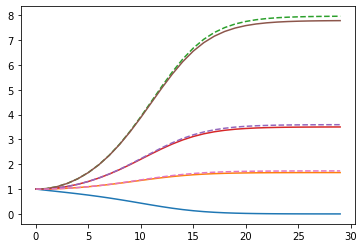

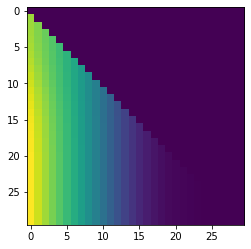

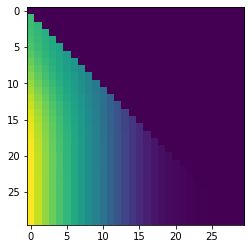

In [6]:
plt.plot(Delta)
plt.plot(jnp.diag(H1))
plt.plot(jnp.diag(G1), '--')
plt.plot(jnp.diag(H2))
plt.plot(jnp.diag(G2), '--')
plt.plot(jnp.diag(H3))
plt.plot(jnp.diag(G3),'--')
plt.show()

plt.imshow(A1)
plt.show()
plt.imshow(B1)
plt.show()

In [7]:
print(Delta)

[1.0000000e+00 9.5200002e-01 9.0571159e-01 8.5898024e-01 8.1018817e-01
 7.5809407e-01 7.0180404e-01 6.4083475e-01 5.7523966e-01 5.0576133e-01
 4.3394494e-01 3.6211661e-01 2.9313719e-01 2.2991592e-01 1.7480749e-01
 1.2913129e-01 9.3021326e-02 6.5635808e-02 4.5568176e-02 3.1253878e-02
 2.1247944e-02 1.4355600e-02 9.6570505e-03 6.4770598e-03 4.3354584e-03
 2.8980137e-03 1.9353884e-03 1.2917221e-03 8.6177024e-04 5.7477073e-04]


In [8]:
#order_params = [ H1, H2, G1, G2, A,B, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T) ]
order_params = [ H1, H2, H3, G1, G2, G3, A1, B1, A2, B2, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T) ]


In [9]:
#Hess = hessian(action_full_direct_integral)(order_params, eta, gamma)
Hess = hessian(action_four_full_direct_integral)(order_params, eta, gamma)

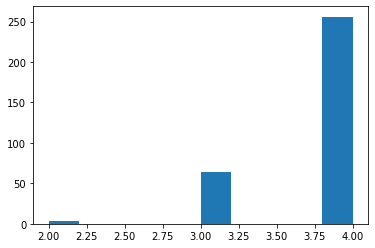

In [10]:
len(Hess)
# spits out a 10 x 10 list of lists
total_count = 0.0
all_shapes = []
for i, hi in enumerate(Hess):
    for j, hij in enumerate(hi):
        all_shapes += [len(hij.shape)]
        
plt.hist(all_shapes)
plt.show()


In [27]:
total_size = 0
for i in range(len(Hess)):
    for j in range(len(Hess[i])):
        size = 1
        for l in Hess[i][j].shape:
            size *= l
        total_size += size

print("theoretical block size")
print((16*T**2+2*T))
print("counting block size")
print(jnp.sqrt(total_size))
#X = np.zeros((4*T**2 + T, 4*T**2 + T))

theoretical block size
14460
counting block size
14460.0


In [11]:
#matrix_dim = 10*T**2 + 2*T
matrix_dim = 16*T**2 + 2*T
X = np.zeros((matrix_dim, matrix_dim))

# first we have H1,H2,G1,G2 => these blocks are zero
# next we have the off diagonal blocks
ind_x = 0
ind_y = 0
for i, param_i in enumerate(order_params):
    prod_i = np.prod(np.array(param_i.shape,dtype='int'))
    #print(f"i = {i}")
    for j, param_j in enumerate(order_params):
        len_i = len(param_i.shape)
        len_j = len(param_j.shape)
        prod_j = np.prod(np.array(param_j.shape,dtype='int'))
        #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
        Hij = Hess[i][j]
        X[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
        ind_y += prod_j
    ind_x += prod_i
    ind_y = 0
print(ind_x)
print(ind_y)

14460
0


In [12]:
propagator = - jnp.linalg.inv(X)

In [13]:
def get_propagator(order_params, eta, gamma):
    Hess = hessian(action_full_direct_integral)(order_params, eta, gamma)
    ind_x = 0
    ind_y = 0
    matrix_dim = 10 * T**2 + 2*T
    X = np.zeros((matrix_dim, matrix_dim))
    for i, param_i in enumerate(order_params):
        prod_i = np.prod(np.array(param_i.shape,dtype='int'))
        #print(f"i = {i}")
        for j, param_j in enumerate(order_params):
            len_i = len(param_i.shape)
            len_j = len(param_j.shape)
            prod_j = np.prod(np.array(param_j.shape,dtype='int'))
            #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
            Hij = Hess[i][j]
            X[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
            ind_y += prod_j
        ind_x += prod_i
        ind_y = 0
    
    propagator = - jnp.linalg.inv(X)
    return propagator

def get_propagator4(order_params, eta, gamma):
    Hess = hessian(action_four_full_direct_integral)(order_params, eta, gamma)
    #Hess = hessian(action_full_direct_integral)(order_params, eta, gamma)
    ind_x = 0
    ind_y = 0
    matrix_dim = 16 * T**2 + 2*T
    X = np.zeros((matrix_dim, matrix_dim))
    for i, param_i in enumerate(order_params):
        prod_i = np.prod(np.array(param_i.shape,dtype='int'))
        #print(f"i = {i}")
        for j, param_j in enumerate(order_params):
            len_i = len(param_i.shape)
            len_j = len(param_j.shape)
            prod_j = np.prod(np.array(param_j.shape,dtype='int'))
            #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
            Hij = Hess[i][j]
            X[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
            ind_y += prod_j
        ind_x += prod_i
        ind_y = 0
    
    propagator = - jnp.linalg.inv(X)
    return propagator

In [14]:
print(propagator)
Sigma_H1 = propagator[0:T**2,0:T**2].reshape((T,T,T,T))
Sigma_H2 = propagator[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))
Sigma_H3 = propagator[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
Sigma_G1 = propagator[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))
Sigma_G2 = propagator[4*T**2:5*T**2,4*T**2:5*T**2].reshape((T,T,T,T))
Sigma_G3 = propagator[5*T**2:6*T**2,5*T**2:6*T**2].reshape((T,T,T,T))
Sigma_Delta = propagator[10*T**2:10*T**2+T,10*T**2:10*T**2+T].reshape((T,T))

#Sigma_G1 = propagator[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
#Sigma_G2 = propagator[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))
#Sigma_Delta = propagator[6*T**2:6*T**2+T,6*T**2:6*T**2+T].reshape((T,T))


[[ 2.         2.         2.0071228 ... -0.        -0.        -0.       ]
 [ 2.         2.         2.0071292 ... -0.        -0.        -0.       ]
 [ 2.0071228  2.0071292  2.0143156 ... -0.        -0.        -0.       ]
 ...
 [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
 [-0.        -0.        -0.        ... -0.        -0.        -0.       ]
 [-0.        -0.        -0.        ... -0.        -0.        -0.       ]]


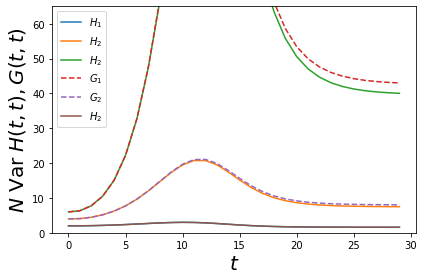

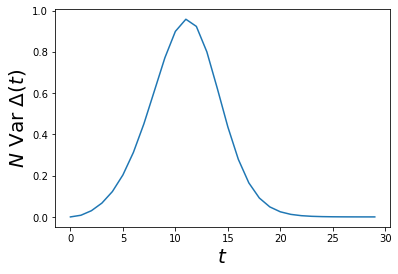

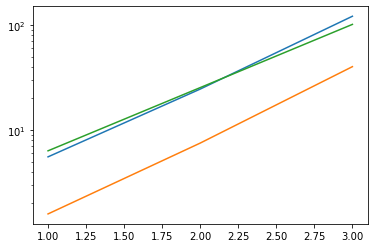

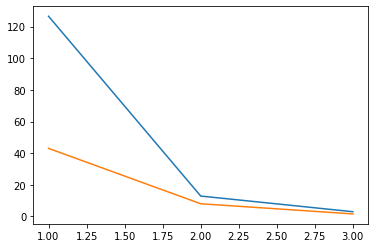

In [28]:
plt.plot(  jnp.einsum('iiii->i', Sigma_H1) , label = r'$H_1$')
plt.plot(  jnp.einsum('iiii->i', Sigma_H2) ,label = r'$H_2$')
plt.plot(  jnp.einsum('iiii->i', Sigma_H3) ,label = r'$H_2$')

plt.plot(  jnp.einsum('iiii->i', Sigma_G1) ,  '--',label = r'$G_1$')
plt.plot(  jnp.einsum('iiii->i', Sigma_G2) ,  '--',label = r'$G_2$')
plt.plot(  jnp.einsum('iiii->i', Sigma_G3) ,label = r'$H_2$')

plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $H(t,t), G(t,t)$',fontsize = 20)
plt.ylim([0,65])
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(jnp.diag(Sigma_Delta))
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $\Delta(t)$',fontsize = 20)
plt.show()


# kappa1 = 2 H1, kappa2 = 2 H2 , kappa3 =
plt.semilogy([1,2,3],[2 * H1[-1,-1]**2, 2 * H2[-1,-1]**2, 2 * H3[-1,-1]**2])
plt.semilogy([1,2,3],[Sigma_H1[-1,-1,-1,-1], Sigma_H2[-1,-1,-1,-1], Sigma_H3[-1,-1,-1,-1]])
plt.semilogy([1,2,3],[ 2*jnp.sqrt(1+gamma**2), 8*jnp.sqrt(1+gamma**2), 32*jnp.sqrt(1+gamma**2) ])
plt.show()

plt.plot([1,2,3],[2* G1[-1,-1]**2, G2[-1,-1]**2, G3[-1,-1]**2])
plt.plot([1,2,3],[Sigma_G1[-1,-1,-1,-1], Sigma_G2[-1,-1,-1,-1], Sigma_G3[-1,-1,-1,-1]])
plt.show()


In [30]:
from jax.example_libraries import optimizers
from jax import grad, lax, vmap, random
# defined with params_tr = [w2, W0], W1 will be fixed and random
def NN_func(params_tr, W1, x):
    w2,W0 = params_tr
    N = w2.shape[0]
    D = x.shape[0]
    h = 1.0/jnp.sqrt(D)*W0 @ x
    h = 1.0/jnp.sqrt(N)*W1 @ h
    f = 1.0/N * jnp.dot(w2,h) 
    return f

def compute_H(params_tr, W1, x):
    w2,W0 = params_tr
    return


# initializer
def construct_NN(N, D, key):
    return [random.normal( random.fold_in(key, 1), (N,)), random.normal(random.fold_in(key, 2), (N,N)), random.normal(random.fold_in(key, 3), (N,D))]


def construct_NN4(N, D, key):
    return [random.normal( random.fold_in(key, 1), (N,)), random.normal(random.fold_in(key, 2), (N,N)), random.normal(random.fold_in(key, 3), (N,N)), random.normal(random.fold_in(key, 4), (N,D))]


# takes in initial params and spits out trained network
def train_three_layer_frozen_middle(N, D, gamma, eta0, x, y, T = 10, E=100):
    
    shift_apply = lambda params, params0, W1: 1.0*( NN_func(params, W1, x)-NN_func(params0, W1, x) )/gamma
    #shift_apply = lambda params, params0, W1:
    loss_fn = lambda params, params0, W1: 0.5*jnp.mean( (shift_apply(params,params0,W1) - y)**2 )
    Delta_fn = lambda params, params0, W1: y - shift_apply(params, params0,W1)

    grad_fn = grad(loss_fn,0)
    eta_true = N * gamma**2 * eta0
    opt_init, opt_update, get_params = optimizers.sgd(eta_true)
    update_fn = lambda s, s0, W1, t: opt_update(t, grad_fn(get_params(s), get_params(s0), W1), s)
    
    def carry_out(ss0, t):
        s, s0, W1 = ss0 # optstate, optstate0, middle weights
        train_Delta = Delta_fn(get_params(s), get_params(s0), W1)
        #K = NTK_fn(get_params(s))
        #kappa = kappa_fn(get_params(s))
        return [ [update_fn(s,s0,W1,t), s0, W1] , train_Delta ]
    
    train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
    def init_fully(seed, N):
        w2, W1, W0 = construct_NN(N, D, random.PRNGKey(seed))
        params = [w2,W0]
        s =  opt_init(params)
        return [s,s, W1] # gets the ss0 datastructure
    
    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1,E,step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, Delta_tr = vmap(train)(ss_mapped) # train w/ vectorization
    
    return Delta_tr



def NN_func_full(params, x):
    w2,W1,W0 = params
    N = w2.shape[0]
    D = x.shape[0]
    h = 1.0/jnp.sqrt(D)*W0 @ x
    h = 1.0/jnp.sqrt(N)*W1 @ h
    f = 1.0/N * jnp.dot(w2,h) 
    return f

def NN_func4(params,x):
    w3,W2,W1,W0 = params
    N = w3.shape[0]
    D = x.shape[0]
    h = 1.0/jnp.sqrt(D)*W0 @ x
    h = 1.0/jnp.sqrt(N)*W1 @ h
    h = 1.0/jnp.sqrt(N)*W2 @ h
    f = 1.0/N * jnp.dot(w3,h) 
    return f


def NN_func4_multi(params,x):
    w3,W2,W1,W0 = params
    N = w3.shape[0]
    D = x.shape[0]
    h = 1.0/jnp.sqrt(D)*W0 @ x
    h = 1.0/jnp.sqrt(N)*W1 @ h
    h = 1.0/jnp.sqrt(N)*W2 @ h
    f = 1.0/N * h.T @ w3  
    return f

def get_H(params,x):
    w2,W1,W0 = params
    N = w2.shape[0]
    h = 1.0/jnp.sqrt(D) * W0 @ x
    H1 = 1.0/N * jnp.dot(h,h)
    h = 1.0/jnp.sqrt(N) * W1 @ h
    H2 = 1/N * jnp.dot(h,h)
    return [H1,H2]


def get_G(params,x):
    w2,W1,W0 = params
    N = w2.shape[0]
    G2 = jnp.dot(w2,w2)/N
    g1 = 1/jnp.sqrt(N) * W1.T @ w2
    G1= 1.0/N * jnp.dot(g1,g1)
    return [G1,G2]


def get_H4(params,x):
    w3,W2,W1,W0 = params
    N = w3.shape[0]
    h = 1.0/jnp.sqrt(D) * W0 @ x
    H1 = 1.0/N * jnp.dot(h,h)
    h = 1.0/jnp.sqrt(N) * W1 @ h
    H2 = 1/N * jnp.dot(h,h)
    h = 1.0/jnp.sqrt(N) * W2 @ h
    H3 = 1/N * jnp.dot(h,h)

    return [H1,H2,H3]


def get_G4(params,x):
    w3,W2,W1,W0 = params
    N = w3.shape[0]
    G3 = jnp.dot(w3,w3)/N
    g2 = 1/jnp.sqrt(N) * W2.T @ w3
    G2= 1.0/N * jnp.dot(g2,g2)
    g1 = 1/jnp.sqrt(N) * W1.T @ g2
    G1= 1.0/N * jnp.dot(g1,g1)
    return [G1,G2,G3]

def train_three_layer_full(N, D, gamma, eta0, x, y, T = 10, E=100):
    
    shift_apply = lambda params, params0: 1.0*( NN_func_full(params, x) - NN_func_full(params0, x) )/gamma
    #shift_apply = lambda params, params0: 1.0 * NN_func_full(params,x) /gamma
    loss_fn = lambda params, params0: 0.5*jnp.mean( (shift_apply(params,params0) - y)**2 )
    Delta_fn = lambda params, params0: y - shift_apply(params, params0)

    grad_fn = grad(loss_fn,0)
    eta_true = N * gamma**2 * eta0
    opt_init, opt_update, get_params = optimizers.sgd(eta_true)
    update_fn = lambda s, s0, t: opt_update(t, grad_fn(get_params(s), get_params(s0)), s)
    
    def carry_out(ss0, t):
        s, s0 = ss0 # optstate, optstate0, middle weights
        train_Delta = Delta_fn(get_params(s), get_params(s0))
        H1,H2 = get_H(get_params(s), x)
        G1,G2 = get_G(get_params(s), x)
        #K = NTK_fn(get_params(s))
        #kappa = kappa_fn(get_params(s))
        return [ [update_fn(s,s0,t), s0] , [train_Delta,H1,H2,G1,G2] ]
    
    train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
    def init_fully(seed, N):
        params = construct_NN(N, D, random.PRNGKey(seed))
        s =  opt_init(params)
        return [s,s] # gets the ss0 datastructure
    
    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1, E, step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, Delta_H_tr = vmap(train)(ss_mapped) # train w/ vectorization
    
    return Delta_H_tr


def train_four_layer_full(N, D, gamma, eta0, x, y, T = 10, E=100):
    
    shift_apply = lambda params, params0: 1.0*( NN_func4(params, x) - NN_func4(params0, x) )/gamma
    #shift_apply = lambda params, params0: 1.0 * NN_func_full(params,x) /gamma
    loss_fn = lambda params, params0: 0.5*jnp.mean( (shift_apply(params,params0) - y)**2 )
    Delta_fn = lambda params, params0: y - shift_apply(params, params0)

    grad_fn = grad(loss_fn,0)
    eta_true = N * gamma**2 * eta0
    opt_init, opt_update, get_params = optimizers.sgd(eta_true)
    update_fn = lambda s, s0, t: opt_update(t, grad_fn(get_params(s), get_params(s0)), s)
    
    def carry_out(ss0, t):
        s, s0 = ss0 # optstate, optstate0, middle weights
        train_Delta = Delta_fn(get_params(s), get_params(s0))
        H1,H2,H3 = get_H4(get_params(s), x)
        G1,G2,G3 = get_G4(get_params(s), x)
        #K = NTK_fn(get_params(s))
        #kappa = kappa_fn(get_params(s))
        return [ [update_fn(s,s0,t), s0] , [train_Delta,H1,H2,H3,G1,G2,G3] ]
    
    train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
    def init_fully(seed, N):
        params = construct_NN4(N, D, random.PRNGKey(seed))
        s =  opt_init(params)
        return [s,s] # gets the ss0 datastructure
    
    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1, E, step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, Delta_H_tr = vmap(train)(ss_mapped) # train w/ vectorization
    
    return Delta_H_tr


def train_four_layer_full_multi(N, D, gamma, eta0, x, y, T = 10, E=100):
    
    shift_apply = lambda params, params0: 1.0*( NN_func4_multi(params, x) - NN_func4_multi(params0, x) )/gamma
    #shift_apply = lambda params, params0: 1.0 * NN_func_full(params,x) /gamma
    loss_fn = lambda params, params0: 0.5*jnp.sum( (shift_apply(params,params0) - y)**2 )
    Delta_fn = lambda params, params0: y - shift_apply(params, params0)

    grad_fn = grad(loss_fn,0)
    eta_true = N * gamma**2 * eta0
    opt_init, opt_update, get_params = optimizers.sgd(eta_true)
    update_fn = lambda s, s0, t: opt_update(t, grad_fn(get_params(s), get_params(s0)), s)
    
    def carry_out(ss0, t):
        s, s0 = ss0 # optstate, optstate0, middle weights
        train_Delta = Delta_fn(get_params(s), get_params(s0))
        #H1,H2,H3 = get_H4(get_params(s), x)
        #G1,G2,G3 = get_G4(get_params(s), x)
        #K = NTK_fn(get_params(s))
        #kappa = kappa_fn(get_params(s))
        return [ [update_fn(s,s0,t), s0] , train_Delta ]
    
    train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
    def init_fully(seed, N):
        params = construct_NN4(N, D, random.PRNGKey(seed))
        s =  opt_init(params)
        return [s,s] # gets the ss0 datastructure
    
    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1, E, step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, Delta_H_tr = vmap(train)(ss_mapped) # train w/ vectorization
    
    return Delta_H_tr

In [32]:
D = 50
x = random.normal(random.PRNGKey(0), (D,))
x = x / jnp.sqrt(jnp.mean(x**2))
y = 1.0
N = 250
#Deltas = train_three_layer_frozen_middle(N,D,  gamma, eta0, x, y)
#Delta_expt, H1_expt, H2_expt, G1_expt, G2_expt = train_three_layer_full(N,D,  gamma, eta, x, y, T=T, E = 1000)
Delta_expt, H1_expt, H2_expt, H3_expt, G1_expt, G2_expt, G3_expt = train_four_layer_full(N,D,  gamma, eta, x, y, T=T, E = 500)

P = D
y_vec = np.zeros(P)
y_vec[0] = 1.0
y_vec = jnp.array(y_vec)
X, _ = jnp.linalg.qr(random.normal(random.PRNGKey(0),(D,P) ) )
X = X * jnp.sqrt(D)
Delta_multi = train_four_layer_full_multi(N, D, gamma, eta, X, y_vec, T = T, E=500)


(499, 30, 50)


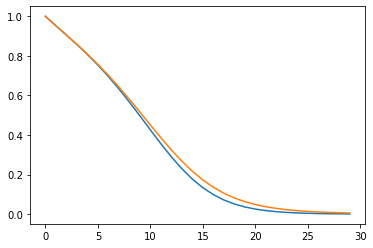

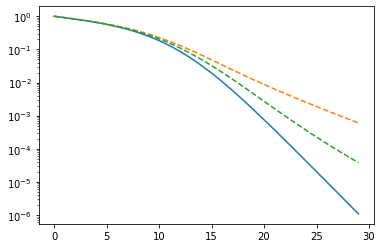

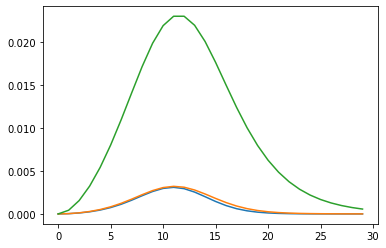

In [42]:
print(Delta_multi.shape)
plt.plot(Delta_expt.mean(axis=0))
#plt.plot(Delta, '--', color = 'black')
plt.plot(Delta_multi.mean(axis=0).sum(axis = 1))
plt.show()

plt.semilogy(jnp.mean(Delta_expt**2, axis = 0))
plt.semilogy(jnp.mean(Delta_multi**2, axis = 0).sum(axis =1), '--')
plt.semilogy(jnp.mean(Delta_multi[:,:,0]**2, axis = 0), '--')
plt.show()

plt.plot(Delta_expt.var(axis=0))
plt.plot(Delta_multi[:,:,0].var(axis=0))
plt.plot(Delta_multi.var(axis=0).sum(axis=1))
plt.show()

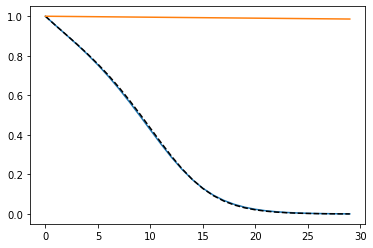

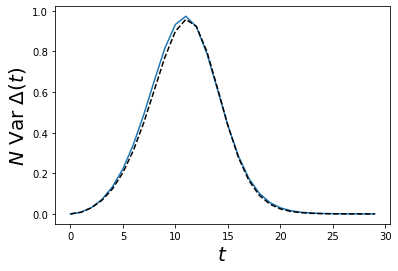

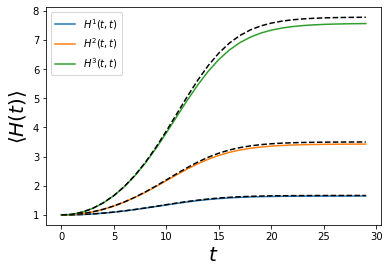

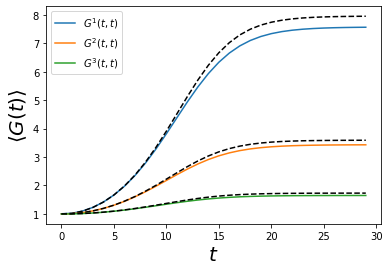

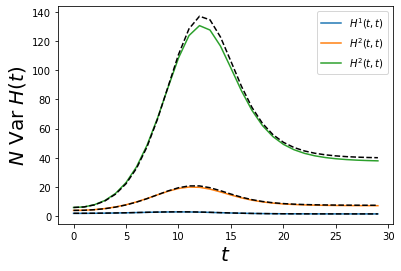

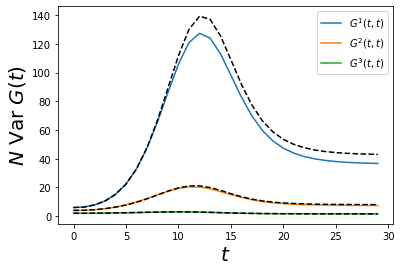

In [36]:
#plt.plot(Deltas.mean(axis = 0))
plt.plot(Delta_expt.mean(axis=0))
plt.plot(Delta, '--', color = 'black')
plt.plot(Delta_multi.mean(axis=0).sum(axis = 1))
plt.show()

#plt.plot(N * Deltas.var(axis =0))
plt.plot(N*Delta_expt.var(axis=0))
plt.plot(jnp.diag(Sigma_Delta), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $\Delta(t)$',fontsize =20)
plt.show()

plt.plot(H1_expt.mean(axis=0), label = r'$H^1(t,t)$')
plt.plot(jnp.diag(H1), '--', color = 'black')
plt.plot(H2_expt.mean(axis=0), label = r'$H^2(t,t)$')
plt.plot(jnp.diag(H2),'--', color = 'black')
plt.plot(H3_expt.mean(axis=0), label = r'$H^3(t,t)$')
plt.plot(jnp.diag(H3),'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left<  H(t) \right>$',fontsize =20)
plt.legend()
plt.show()


plt.plot(G1_expt.mean(axis=0), label = r'$G^1(t,t)$')
plt.plot(jnp.diag(G1), '--', color = 'black')
plt.plot(G2_expt.mean(axis=0), label = r'$G^2(t,t)$')
plt.plot(jnp.diag(G2),'--', color = 'black')
plt.plot(G3_expt.mean(axis=0), label = r'$G^3(t,t)$')
plt.plot(jnp.diag(G3),'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left<  G(t) \right>$',fontsize =20)
plt.legend()
plt.show()

plt.plot(N*H1_expt.var(axis=0), label = r'$H^1(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_H1), '--', color = 'black')
plt.plot(N * H2_expt.var(axis=0), label = r'$H^2(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_H2),'--', color = 'black')
plt.plot(N * H3_expt.var(axis=0), label = r'$H^2(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_H3),'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $H(t)$',fontsize =20)
plt.legend()
plt.show()


plt.plot(N*G1_expt.var(axis=0) , label = r'$G^1(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_G1), '--', color = 'black')
plt.plot(N * G2_expt.var(axis=0) , label = r'$G^2(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_G2),'--', color = 'black')
plt.plot(N * G3_expt.var(axis=0) , label = r'$G^3(t,t)$')
plt.plot(jnp.einsum('iiii->i',Sigma_G3),'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $G(t)$',fontsize =20)
plt.legend()
plt.show()



In [33]:
eta = 0.015
T = 30
N = 1000
gamma_vals = [0.5, 1.0, 2.0, 3.0]

Deltas_dmft = []
Deltas_var = []
Deltas_expt = []

H1s_dmft = []
H2s_dmft = []
H3s_dmft = []
G1s_dmft = []
G2s_dmft = []
G3s_dmft = []

all_Sigma_H1=[]
all_Sigma_H2 = []
all_Sigma_H3 = []
all_Sigma_G1 = []
all_Sigma_G2 = []
all_Sigma_G3 = []

all_H1_expt = []
all_H2_expt = []
all_H3_expt = []

all_G1_expt = []
all_G2_expt = []
all_G3_expt = []

for i, gamma in enumerate(gamma_vals):
    #H1, G1, H2, G2, A, B, Delta = solve_sp_eqn(eta, gamma, T=T, num_iter = 100)
    H1, G1, H2, G2, H3, G3, A1, B1, A2, B2, Delta = solve_sp_eqn_four(eta, gamma, T=T, num_iter = 100)
    Deltas_dmft += [Delta]
    H1s_dmft += [jnp.diag(H1)]
    H2s_dmft += [jnp.diag(H2)]
    H3s_dmft += [jnp.diag(H3)]
    G1s_dmft += [jnp.diag(G1)]
    G2s_dmft += [jnp.diag(G2)]
    G3s_dmft += [jnp.diag(G3)]
    order_params = [ H1, H2, H3, G1, G2, G3, A1, B1, A2, B2, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T) ]
    #order_params = [ H1, H2, G1, G2, A, B, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T) ]
    propagator = get_propagator4(order_params, eta, gamma)
    #Sigma_Delta = propagator[10*T**2:10*T**2+T,10*T**2:10*T**2+T].reshape((T,T))
    #Sigma_H1 = propagator[0:T**2,0:T**2].reshape((T,T,T,T))
    #Sigma_H2 = propagator[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))
    #Sigma_G1 = propagator[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
    #Sigma_G2 = propagator[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))
    Sigma_H1 = propagator[0:T**2,0:T**2].reshape((T,T,T,T))
    Sigma_H2 = propagator[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))
    Sigma_H3 = propagator[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
    Sigma_G1 = propagator[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))
    Sigma_G2 = propagator[4*T**2:5*T**2,4*T**2:5*T**2].reshape((T,T,T,T))
    Sigma_G3 = propagator[5*T**2:6*T**2,5*T**2:6*T**2].reshape((T,T,T,T))
    Sigma_Delta = propagator[10*T**2:10*T**2+T,10*T**2:10*T**2+T].reshape((T,T))
    
    all_Sigma_H1 += [ jnp.einsum('iijj->ij', Sigma_H1)]
    all_Sigma_H2 += [ jnp.einsum('iijj->ij', Sigma_H2)]
    all_Sigma_H3 += [ jnp.einsum('iijj->ij', Sigma_H3)]

    all_Sigma_G1 += [ jnp.einsum('iijj->ij', Sigma_G1)]
    all_Sigma_G2 += [ jnp.einsum('iijj->ij', Sigma_G2)]
    all_Sigma_G3 += [ jnp.einsum('iijj->ij', Sigma_G3)]
    
    Deltas_var += [ jnp.diag(Sigma_Delta) ]
    
    #Delta_exp, H1_exp, H2_exp, G1_exp, G2_exp =  train_three_layer_full(N, D, gamma, eta, x, y, T=T, E = 1000)
    Delta_exp, H1_exp, H2_exp, H3_exp, G1_exp, G2_exp, G3_exp = train_four_layer_full(N,D,  gamma, eta, x, y, T=T, E = 1000)
    Deltas_expt += [Delta_exp]
    all_H1_expt += [H1_exp]
    all_H2_expt += [H2_exp]
    all_H3_expt += [H3_exp]
    all_G1_expt += [G1_exp]
    all_G2_expt += [G2_exp]
    all_G3_expt += [G3_exp]
    

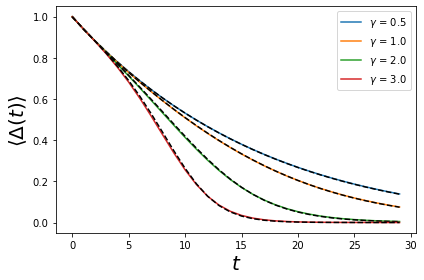

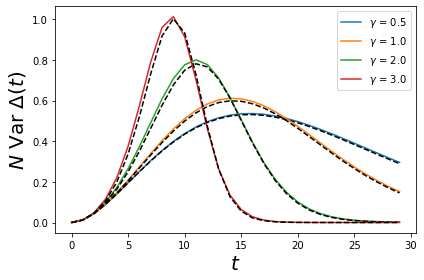

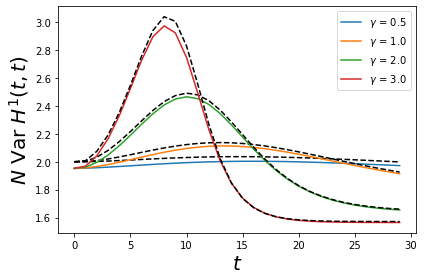

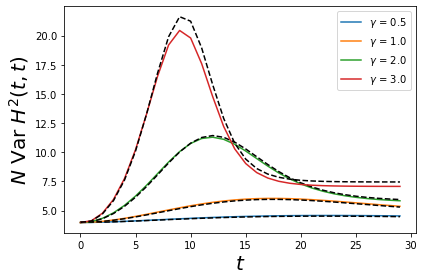

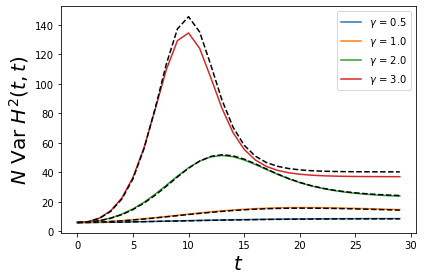

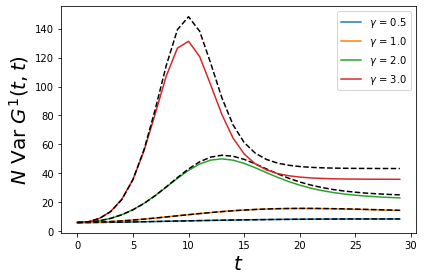

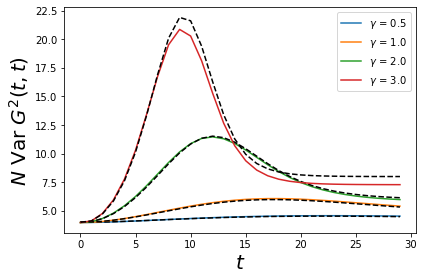

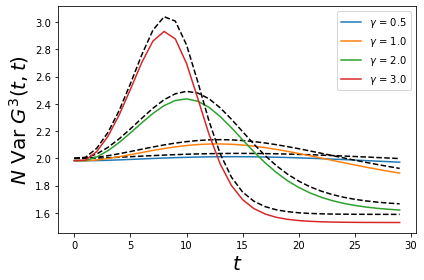

In [9]:
for i, gamma in enumerate(gamma_vals):
    plt.plot(Deltas_expt[i].mean(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(Deltas_dmft[i],'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left< \Delta(t) \right>$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_Delta_mean.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
    plt.plot(N * Deltas_expt[i].var(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (Deltas_expt[i]-Deltas_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')

    plt.plot(Deltas_var[i],'--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $\Delta(t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_Delta_var.pdf')
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(N * all_H1_expt[i].var(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_H1_expt[i]-H1s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_H1[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $H^1(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_H1_var.pdf')
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(N * all_H2_expt[i].var(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_H2_expt[i]-H2s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_H2[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $H^2(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_H2_var.pdf')
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(N * all_H3_expt[i].var(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_H2_expt[i]-H2s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_H3[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $H^2(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_H3_var.pdf')
plt.show()


for i, gamma in enumerate(gamma_vals):
    plt.plot(N * all_G1_expt[i].var(axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_G1_expt[i]-G1s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_G1[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $G^1(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_G1_var.pdf')
plt.show()

# technically not the variance, but squared deviation from dmft 
for i, gamma in enumerate(gamma_vals):
    G2_var_expt = N * all_G2_expt[i].var(axis =0)
    #G2_var_expt = G2_var_expt / G2_var_expt[0] * all_Sigma_G2[i][0]
    plt.plot(G2_var_expt, label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_G2_expt[i]-G2s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_G2[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $G^2(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_G2_var.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
    G3_var_expt = N * all_G3_expt[i].var(axis =0)
    #G2_var_expt = G2_var_expt / G2_var_expt[0] * all_Sigma_G2[i][0]
    plt.plot(G3_var_expt, label = f'$\gamma$ = {gamma:0.1f}')
    #plt.plot(N * jnp.mean( (all_G2_expt[i]-G2s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.plot(jnp.diag(all_Sigma_G3[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $G^3(t,t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_4_vary_gamma_G3_var.pdf')
plt.show()

In [10]:
all_NTK_var_exp = []
all_NTK_var_dmft = []

all_NTK_exp = []
all_NTK_dmft = []

for i, gamma in enumerate(gamma_vals):
    H1_var_exp = N * all_H1_expt[i].var(axis =0)
    H2_var_exp = N * all_H2_expt[i].var(axis =0)
    H3_var_exp = N * all_H3_expt[i].var(axis =0)
    
    NTK_var_exp = H1_var_exp * all_G2_expt[i].mean(axis=0) + H2_var_exp * all_G3_expt[i].mean(axis=0) + H3_var_exp
    G1_var_exp = N * all_G1_expt[i].var(axis =0)
    G2_var_exp = N * all_G2_expt[i].var(axis =0)
    G3_var_exp = N * all_G3_expt[i].var(axis =0)
    
    NTK_var_exp += G1_var_exp + G2_var_exp * all_H1_expt[i].mean(axis = 0 ) + G3_var_exp * all_H2_expt[i].mean(axis=0)
    
    all_NTK_var_exp += [NTK_var_exp]
    
    H1_var_dmft = jnp.diag(all_Sigma_H1[i])
    H2_var_dmft = jnp.diag(all_Sigma_H2[i])
    H3_var_dmft = jnp.diag(all_Sigma_H3[i])
    
    NTK_var_dmft = H1_var_exp * G2s_dmft[i] + H2_var_exp * G3s_dmft[i] + H3_var_exp
    G1_var_exp = jnp.diag(all_Sigma_G1[i])
    G2_var_exp = jnp.diag(all_Sigma_G2[i])
    G3_var_exp = jnp.diag(all_Sigma_G3[i])
    
    NTK_var_dmft += G1_var_exp + G2_var_exp * H1s_dmft[i] + G3_var_exp * H2s_dmft[i]
    
    all_NTK_var_dmft += [NTK_var_dmft]
    
    all_NTK_exp += [all_G1_expt[i].mean(axis=0)+all_G2_expt[i].mean(axis=0)*all_H1_expt[i].mean(axis=0)+all_G3_expt[i].mean(axis=0)*all_H2_expt[i].mean(axis=0) + all_H3_expt[i].mean(axis=0) ] 
    
    all_NTK_dmft += [ G1s_dmft[i] + G2s_dmft[i] * H1s_dmft[i] + G3s_dmft[i]*H2s_dmft[i] + H3s_dmft[i] ]
    

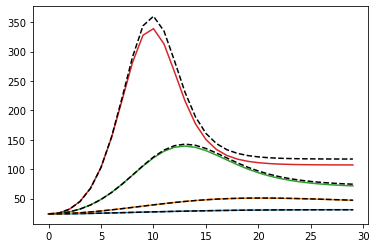

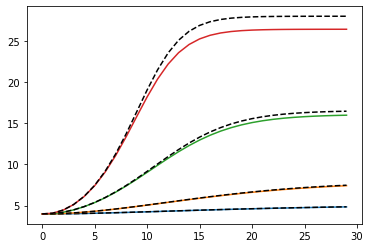

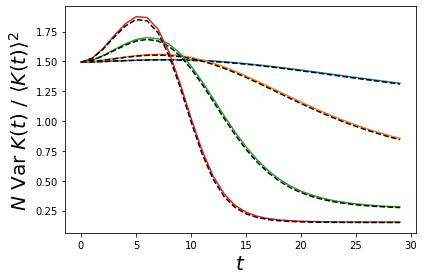

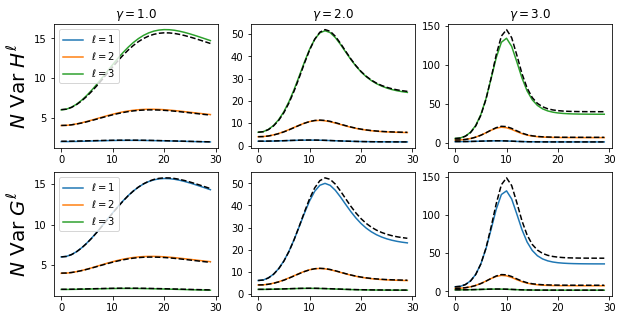

In [36]:
for i,NTKvar in enumerate(all_NTK_var_exp):
    plt.plot(NTKvar)
    plt.plot(all_NTK_var_dmft[i], '--', color = 'black')
plt.show()

for i, NTK in enumerate(all_NTK_exp):
    plt.plot(NTK)
    plt.plot(all_NTK_dmft[i], '--',color = 'black')
plt.show()

for i,NTKvar in enumerate(all_NTK_var_exp):
    plt.plot(NTKvar / all_NTK_exp[i]**2)
    plt.plot(all_NTK_var_dmft[i]/all_NTK_dmft[i]**2, '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $K(t) \ / \ \left<K(t) \right>^2$ ', fontsize = 20)
plt.tight_layout()
plt.savefig('figures/ntk_snr_vs_gamma_depth4.pdf')
plt.show()

plt.figure(figsize = (10,5))
plt.subplot(2, 3, 1)
plt.title('$\gamma = %0.1f$' % gamma_vals[1])
plt.plot(N * all_H1_expt[1].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_H2_expt[1].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_H3_expt[1].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_H1[1]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H2[1]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H3[1]),'--',color = 'black')
plt.ylabel(r'$N$ Var $H^\ell$',fontsize=20)
plt.legend()
plt.subplot(2, 3, 4)
plt.plot(N * all_G1_expt[1].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_G2_expt[1].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_G3_expt[1].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_G1[1]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G2[1]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G3[1]),'--',color = 'black')
plt.ylabel(r'$N$ Var $G^\ell$',fontsize=20)
plt.legend()

plt.subplot(2, 3, 2)
plt.title('$\gamma = %0.1f$' % gamma_vals[2])
plt.plot(N * all_H1_expt[2].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_H2_expt[2].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_H3_expt[2].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_H1[2]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H2[2]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H3[2]),'--',color = 'black')
plt.subplot(2, 3, 5)
plt.plot(N * all_G1_expt[2].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_G2_expt[2].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_G3_expt[2].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_G1[2]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G2[2]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G3[2]),'--',color = 'black')
#plt.plot(N * jnp.mean( (all_H1_expt[i]-H1s_dmft[i][jnp.newaxis,:] )**2 ,axis=0), label = f'$\gamma$ = {gamma:0.1f}')
#plt.plot(jnp.diag(all_Sigma_H1[i]), '--', color = 'black')   

plt.subplot(2, 3, 3)
plt.title('$\gamma = %0.1f$' % gamma_vals[3])
plt.plot(N * all_H1_expt[3].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_H2_expt[3].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_H3_expt[3].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_H1[3]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H2[3]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_H3[3]),'--',color = 'black')
plt.subplot(2, 3, 6)
plt.plot(N * all_G1_expt[3].var(axis =0), label = f'$\ell = 1$')
plt.plot(N * all_G2_expt[3].var(axis =0), label = f'$\ell = 2$')
plt.plot(N * all_G3_expt[3].var(axis =0), label = f'$\ell = 3$')
plt.plot(jnp.diag(all_Sigma_G1[3]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G2[3]),'--',color = 'black')
plt.plot(jnp.diag(all_Sigma_G3[3]),'--',color = 'black')

plt.savefig('figures/H_G_var_by_layer_depth4.pdf')
plt.show()

In [ ]:
for i, gamma in enumerate(gamma_vals):
    plt.semilogy(jnp.mean(Deltas_expt[i]**2,axis =0), label = f'$\gamma$ = {gamma:0.1f}')
    plt.semilogy(Deltas_dmft[i]**2 + 1.0/N * Deltas_var[i],'--', color = 'black')
    #plt.semilogy(Deltas_dmft[i]**2 , '--o', color = 'purple')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left< \Delta(t)^2 \right>$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig('figures/depth_3_vary_gamma_Delta_perturbed.pdf')
plt.show()

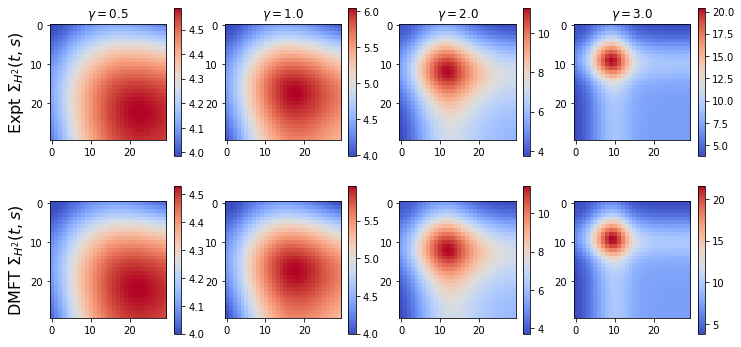

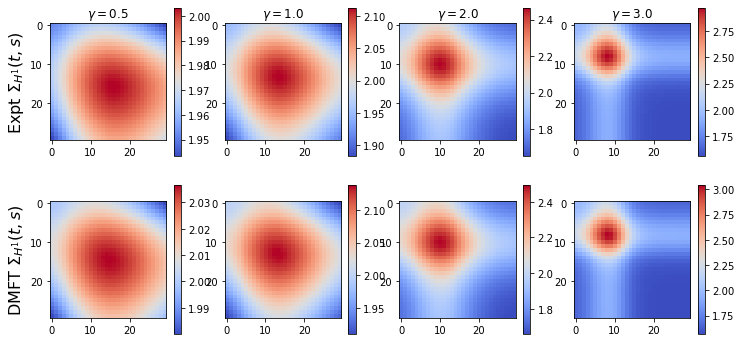

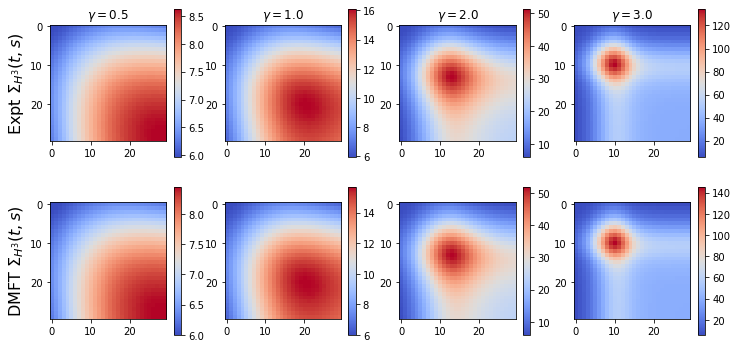

In [42]:
plt.figure(figsize = (12,6))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(2,len(gamma_vals),i+1)
    plt.imshow( N * jnp.einsum('ij,ik->jk', all_H2_expt[i]-all_H2_expt[i].mean(axis=0), all_H2_expt[i]- all_H2_expt[i].mean(axis=0)) / all_H2_expt[-1].shape[0] , cmap = 'coolwarm')
    plt.colorbar()
    if i == 0:
        plt.ylabel(r'Expt $\Sigma_{H^2}(t,s)$',fontsize = 16)
    plt.title(r'$\gamma = %0.1f$' % gamma)
    plt.subplot(2,len(gamma_vals),len(gamma_vals)+i+1)
    plt.imshow( all_Sigma_H2[i], cmap = 'coolwarm')
    if i == 0:
        plt.ylabel(r'DMFT $\Sigma_{H^2}(t,s)$',fontsize =16)
    plt.colorbar()
plt.savefig('figures/DMFT_vs_expt_H2_ts_depth4.pdf')
plt.show()

plt.figure(figsize = (12,6))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(2,len(gamma_vals),i+1)
    plt.imshow( N * jnp.einsum('ij,ik->jk', all_H1_expt[i]-all_H1_expt[i].mean(axis=0), all_H1_expt[i]- all_H1_expt[i].mean(axis=0)) / all_H1_expt[-1].shape[0] , cmap = 'coolwarm')
    plt.colorbar()
    if i == 0:
        plt.ylabel(r'Expt $\Sigma_{H^1}(t,s)$',fontsize = 16)
    plt.title(r'$\gamma = %0.1f$' % gamma)
    plt.subplot(2,len(gamma_vals),len(gamma_vals) + i+1)
    plt.imshow( all_Sigma_H1[i], cmap = 'coolwarm')
    if i == 0:
        plt.ylabel(r'DMFT $\Sigma_{H^1}(t,s)$',fontsize =16)
    plt.colorbar()
plt.savefig('figures/DMFT_vs_expt_H1_ts_depth4.pdf')
plt.show()


plt.figure(figsize = (12,6))
for i, gamma in enumerate(gamma_vals):
    plt.subplot(2,len(gamma_vals),i+1)
    plt.imshow( N * jnp.einsum('ij,ik->jk', all_H3_expt[i]-all_H3_expt[i].mean(axis=0), all_H3_expt[i]- all_H3_expt[i].mean(axis=0)) / all_H3_expt[-1].shape[0] , cmap = 'coolwarm')
    plt.colorbar()
    if i == 0:
        plt.ylabel(r'Expt $\Sigma_{H^3}(t,s)$',fontsize = 16)
    plt.title(r'$\gamma = %0.1f$' % gamma)
    plt.subplot(2,len(gamma_vals),len(gamma_vals) + i+1)
    plt.imshow( all_Sigma_H3[i], cmap = 'coolwarm')
    if i == 0:
        plt.ylabel(r'DMFT $\Sigma_{H^3}(t,s)$',fontsize =16)
    plt.colorbar()
plt.savefig('figures/DMFT_vs_expt_H3_ts_depth4.pdf')
plt.show()

In [ ]:
plt.plot()

In [38]:
# does this work for 2 layer??
def action_depth2(order_params, eta, gamma):
    H, G, Delta, hat_H, hat_G, hat_Delta = order_params
    trace_term = 0.5*(jnp.sum(hat_H * H) + jnp.sum(hat_G * G))  
    T = Delta.shape[0]
    Theta = jnp.tril(jnp.ones((T,T)),k=-1)
    Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
    
    M = jnp.linalg.inv( jnp.eye(T)-gamma**2 * Theta_Delta @ Theta_Delta )
    Sigma_hh = M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
    Sigma_gg = M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
    Sigma_hg = gamma * M @  jnp.ones((T,T)) @ Theta_Delta.T  @ M.T + gamma * M @ Theta_Delta @ jnp.ones((T,T)) @ M.T
    
    schur1_H = jnp.eye(T) + hat_H @ Sigma_hh
    schur1_G = jnp.eye(T) + hat_G @ Sigma_gg
    
    _, log_detH = jnp.linalg.slogdet(schur1_H)
    _, log_detG = jnp.linalg.slogdet(schur1_G - hat_G @ Sigma_hg.T @ jnp.linalg.inv(schur1_H) @ hat_H @ Sigma_hg)
    
    S = trace_term - 0.5 * (log_detH + log_detG)
    
    k = jnp.einsum('ii->i', H + G)
    Theta = jnp.tril( jnp.ones(H.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij',Theta, k)
    Delta_fn = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    S += jnp.dot( hat_Delta , Delta-Delta_fn )
    return S

def action_depth2_discrete(order_params, eta, gamma):
    H, G, Delta, hat_H, hat_G, hat_Delta = order_params
    trace_term = 0.5 * (jnp.sum(hat_H * H) + jnp.sum(hat_G * G))  
    
    T = Delta.shape[0]
    
    Theta = jnp.tril(jnp.ones((T,T)),k=-1)
    Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
    
    M = jnp.linalg.inv( jnp.eye(T) - gamma**2 * Theta_Delta @ Theta_Delta )
    Sigma_hh = M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
    Sigma_gg = M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
    Sigma_hg = gamma * M @  jnp.ones((T,T)) @ Theta_Delta.T  @ M.T + gamma * M @ Theta_Delta @ jnp.ones((T,T)) @ M.T
    
    schur1_H = jnp.eye(T) + hat_H @ Sigma_hh + jnp.diag(hat_Delta) @ Sigma_hg.T
    schur1_G = jnp.eye(T) + hat_G @ Sigma_gg + jnp.diag(hat_Delta) @ Sigma_hg
    
    schur_bl = hat_G @ Sigma_hg.T + jnp.diag(hat_Delta) @ Sigma_hh 
    schur_ur = hat_H @ Sigma_hg + jnp.diag(hat_Delta) @ Sigma_gg 

    _, log_detH = jnp.linalg.slogdet(schur1_H)
    _, log_detG = jnp.linalg.slogdet(schur1_G - schur_bl @ jnp.linalg.inv(schur1_H) @ schur_ur)
    
    S = trace_term - 0.5 * (log_detH + log_detG)
    S += -gamma * jnp.dot( hat_Delta, Delta )
    return S


def solve_two_layer_dmft(eta, gamma, T = 20, num_iter = 25):
    
    H = jnp.ones((T,T))
    G = jnp.ones((T,T))
    Theta = jnp.tril(jnp.ones((T,T)),k=-1)
    k = jnp.einsum('ii->i', H + G)
    Theta_k = jnp.einsum('ij,j->ij',Theta, k)
    Delta = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    for n in range(num_iter):
        Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
        M = jnp.linalg.inv( jnp.eye(T) - gamma**2 * Theta_Delta @ Theta_Delta )
        H_new =  M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
        G_new =  M @ ( jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T
        
        hu = jnp.linalg.solve( jnp.eye(T) - gamma**2 * Theta_Delta @ Theta_Delta, jnp.ones(T) )
        hr = gamma * jnp.linalg.solve( jnp.eye(T) - gamma**2 * Theta_Delta @ Theta_Delta, Theta_Delta @ jnp.ones(T) )
        
        #f = 2.0/gamma * hu * hr
        f = jnp.einsum('ij->i', Theta_Delta)
        Delta_new = 1.0 - f
        #Delta_new = 1.0 - 1.0/gamma * jnp.diag(M @ (jnp.ones((T,T)) + gamma**2 * Theta_Delta @ jnp.ones((T,T)) @ Theta_Delta.T ) @ M.T) 
        
        H = 0.8 * H_new + 0.2 * H
        G = 0.8 * G_new + 0.2 * G
        Delta = 0.8 * Delta_new + 0.2 * Delta
    return H, G, Delta

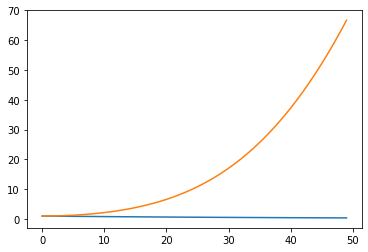

In [133]:
eta = 0.02
gamma= 4.0
T = 50
H, G, Delta = solve_two_layer_dmft(eta, gamma, T = T, num_iter = 75)

plt.plot(Delta)
plt.plot(jnp.diag(H))
plt.show()
order_params = [H, G, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T)]
Hess = hessian(action_depth2)(order_params, eta, gamma)

In [134]:
matrix_dim = 4 * T**2 + 2*T
X = np.zeros((matrix_dim, matrix_dim))

# first we have H1,H2,G1,G2 => these blocks are zero
# next we have the off diagonal blocks
ind_x = 0
ind_y = 0
for i, param_i in enumerate(order_params):
    prod_i = np.prod(np.array(param_i.shape,dtype='int'))
    #print(f"i = {i}")
    for j, param_j in enumerate(order_params):
        len_i = len(param_i.shape)
        len_j = len(param_j.shape)
        prod_j = np.prod(np.array(param_j.shape,dtype='int'))
        #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
        Hij = Hess[i][j]
        X[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
        ind_y += prod_j
    ind_x += prod_i
    ind_y = 0

In [135]:
propagator = - jnp.linalg.inv(X)

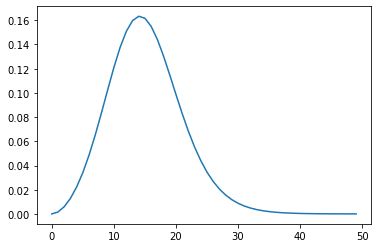

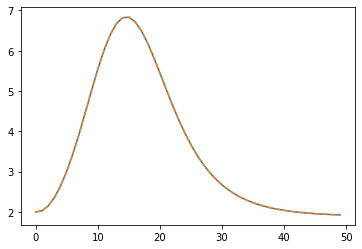

In [49]:
Delta_var = propagator[2*T**2:2*T**2+T,2*T**2:2*T**2+T]
H_var = propagator[0:T**2,0:T**2].reshape((T,T,T,T))
G_var = propagator[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))

plt.plot(jnp.diag(Delta_var))
plt.show()

plt.plot(jnp.einsum('iiii->i', H_var))
plt.plot(jnp.einsum('iiii->i', G_var), '--')
plt.show()

In [50]:
def finite_catapult(N, eta, gamma, T=20, E = 100):

  Delta = np.zeros((T, E))
  K = np.zeros((T,E))
  H = np.zeros((T,E))
  u = random.normal(random.PRNGKey(0), (N,E))
  r = random.normal(random.PRNGKey(1), (N,E))
  h = 1.0 * u
  z = 1.0 * r
  for t in range(T):
    
    K[t,:] = jnp.mean( h**2 + z**2, axis = 0)
    H[t,:] = jnp.mean( h**2 , axis = 0)
    
    if t == 0:
        Delta[t,:] = np.ones(E)
    else:
        Delta[t,:] = Delta[t-1,:] - eta * K[t-1,:] * Delta[t-1,:]
    #Delta[t,:] = 1.0 -  1.0 / gamma * jnp.mean(h*z, axis = 0) 
    
    dh = eta * gamma * jnp.einsum('ij,j->ij', z, Delta[t,:] )
    dz = eta * gamma * jnp.einsum('ij,j->ij', h, Delta[t,:] )
    h += dh
    z += dz
  return Delta, K, H

In [51]:
N = 500
Delta_expt, K_expt, H_expt = finite_catapult(N, eta, gamma, T=T, E = 1000)

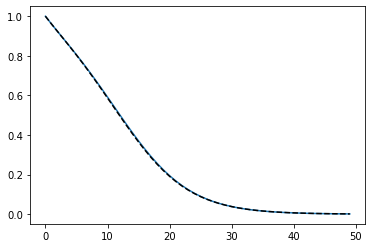

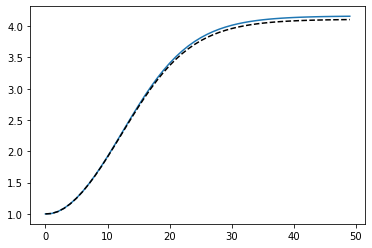

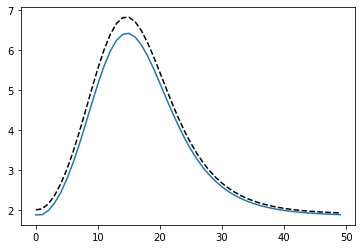

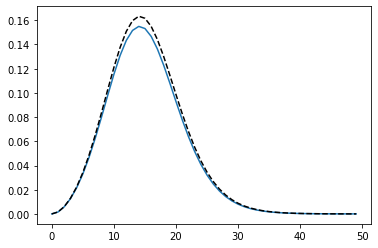

In [52]:
plt.plot(Delta_expt.mean(axis=1))
plt.plot(Delta, '--', color = 'black')
plt.show()

plt.plot(H_expt.mean(axis=1))
plt.plot(jnp.diag(H) ,'--', color = 'black')
plt.show()

plt.plot(N * H_expt.var(axis=1))
plt.plot(jnp.einsum('iiii->i', H_var), '--', color = 'black')
plt.show()
plt.plot(N * Delta_expt.var(axis=1))
plt.plot(jnp.diag(Delta_var), '--', color = 'black')
plt.show()

In [21]:
import jax.numpy as jnp
import numpy as np
from jax import grad, hessian, random
import matplotlib.pyplot as plt

In [4]:

def action_Hess_manual(order_params, eta, gamma):
    
    H1, H2, G1, G2, A, B, Delta, hat_H1, hat_H2, hat_G1, hat_G2, hat_Delta = order_params # note that A,B are their own duals
    
    T = Delta.shape[0]
    Hess = []
    
    zero4 = jnp.zeros((T,T,T,T))
    zero3 = jnp.zeros((T,T,T))
    
    Theta = eta * jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_Delt = jnp.einsum('ij,j->ij', Theta, Delta)
    C1 = gamma * Theta_Delt
    D1 = gamma* ( Theta_Delt * G2 + B )
    C2 = gamma* ( Theta_Delt * H1 + A )
    D2 = gamma * Theta_Delt
    
    M1h = jnp.linalg.inv(jnp.eye(T) - C1 @ D1)
    M1g = jnp.linalg.inv(jnp.eye(T) - D1 @ C1)
    
    M2h = jnp.linalg.inv(jnp.eye(T) - C2 @ D2)
    M2g = jnp.linalg.inv(jnp.eye(T) - D2 @ C2)
    
    dh1_du = M1h 
    dh1_dr = M1h @ C1
    dg1_du = M1g @ D1
    dg1_dr = M1g
    
    # second layer
    dh2_du = M2h
    dh2_dr = M2h @ C2
    dg2_du = M2g @ D2
    dg2_dr = M2g
    
    
    # < h(t) g(s) > correlator  
    HG1 = M1h @ ( jnp.ones((T,T)) @ D1.T + C1 @ G2 ) @ M1g.T
    HG2 = M2h @ ( H1 @ D2.T + C2 @ jnp.ones((T,T)) ) @ M2g.T
    
    # ALL hat{H}_1 BLOCKS START HERE
    S_hatH1_hatH1 = jnp.einsum('ik,jl->ijkl', H1, H1) + jnp.einsum('il,jk->ijkl', H1, H1)     # < h(t) h(t') > < h(s) h(s') > + < h(t) h(s') > < h(s) h(t') >
    S_hatH1_hatG1 = jnp.einsum('ik,jl->ijkl', HG1, HG1) + jnp.einsum('il,jk->ijkl', HG1, HG1) # < h(t) g(t') > < h(s) g(s') > + < h(t) g(s') > < h(s) g(t') >
    S_hatH1_H1 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    
    # explicitly differentiate < d/dB(t',s') h(t)h(s) > 
    
    U_B = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta), H1) # dg(t)/dB(t',s') h(s) = UB + ... =  gamma * delta(t-t') Theta(t-s') < h(s) h(s') >  + ....
    CU_B = jnp.einsum('ij,jklm->iklm', C1, U_B)
    dh_dB_h = jnp.einsum('ij,jklm->iklm', M1h, CU_B) # solves < dh(t)/dB(t',s') h(s)>
    # -i gamma < h(t) h(s) xi(t') h(s')> - gamma H(t,s) A(s',t') = gamma < dh(t)/dr(t') > < h(s) h(s')> + gamma < h(t) h(s') > < dh(s)/dr(t') > 
    S_hatH1_B = -dh_dB_h - dh_dB_h.transpose((1,0,2,3)) - gamma * jnp.einsum('ik,jl->ijkl', dh1_dr, H1 ) - gamma * jnp.einsum('il,jk->ijkl', H1, dh1_dr) 
    
    
    # compute dh/dDelta
    # < dh(t) / dDelta(t')  h(s) > = gamma * Theta(t-t')  < g(t') h(s) > + gamma int_0^t ds' Delta(s') < dg(s')/dDelta(t') h(s) >
    # < dg(t) / dDelta(t')  h(s) > = gamma * Theta(t,t') G2(t,t')  < h(t') h(s) >  + gamma int_0^t ds' D1(t,s') Delta(s') < dh(s')/dDelta(t') h(s) >
    # gamma * Theta(t-t') < g(t') h(s) >
    Theta_HG_1  = gamma * jnp.einsum('ik,jk->ijk', Theta, HG1) # < dh(t)/dDelta(t') h(s) > , t' is k index
    Theta_G_H_1 = gamma * jnp.einsum('ik,jk->ijk', Theta * G2 , H1) # < dg(t)/dDelta(t') h(s) >
    dh_dDelta_h = jnp.einsum('ij,jkl->ikl', M1h, Theta_HG_1 + jnp.einsum('ij,jkl->ikl', C1 , Theta_G_H_1)  )
    
    S_hatH1_Delta = - dh_dDelta_h - dh_dDelta_h.transpose((1,0,2)) # want to symmetrize over first 2 indices
    
    
    # compute hat_H1, G2 derivs: requires < dh1 / dG2 h1 > = ...
    # <dh(t)/dG2(t',s') h(s)> = gamma * int_0^t ds'' Delta(s'') < dg(s'')/dG2(t',s') h(s) >
    # <dg(t)/dG2(t',s') h(s)> = gamma * delta(t-t') Theta(t-s') Delta(s') < g(s') h(s) > + int_0^t ds'' D1(t,s'') < dh(s'')/dG2(t',s') h(s) >
    
    # let U = delta(t-t') Theta(t-s') Delta(s') < h(s) g(s')> 
    U =  gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta_Delt) , HG1 ) # Theta(t-s')Delta(s')delta(t-t')< h(s) g(s') >
    CU = jnp.einsum('ij,jklm->iklm', C1, U) # < dh/dg h > = C <dg/dG h> =  C1 U + C1 D1 <dh/dG h>
    dh_dG2_h = jnp.einsum('ij,jklm->iklm', M1h, CU) # solve (I-CD)^{-1} C U
    
    # d^2 S / dhat{H} dG = - 1/2 < dh(t)/dr(t') dh(s)/dr(s') > - 1/2 < dh(t)/dr(s') dh(s)/dr(t') > - < d/dG h(t) h(s) > 
    S_hatH1_G2 = - 0.5*(jnp.einsum('ik,jl->ijkl',dh1_dr,dh1_dr) + jnp.einsum('il,jk->ijkl',dh1_dr,dh1_dr) ) - dh_dG2_h - dh_dG2_h.transpose((1,0,2,3))
    
    
    # now fill in the hat_H1 entries, the first indices represent hat_H and the second indices represent one of the other order params
    all_hatH1 = [S_hatH1_H1, zero4, zero4, S_hatH1_G2, zero4, S_hatH1_B, S_hatH1_Delta, S_hatH1_hatH1, zero4, S_hatH1_hatG1, zero4, zero3] 
    
    
    # ALL hat{G}_1 BLOCKS START HERE
    S_hatG1_hatG1 = jnp.einsum('ik,jl->ijkl', G1, G1) + jnp.einsum('il,jk->ijkl', G1, G1)   # < g(t) g(t') > < g(s) g(s') > + < g(t) g(s') > < g(s) g(t') >
    S_hatG1_hatH1 = S_hatH1_hatG1.transpose((2,3,0,1)) # d^2 S/dhat{G}(t,s) dhat{H}(t',s')
    S_hatG1_G1 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))

    # now we need to calculate < dg(t)/dB(t',s') g(s) > = UB + ... = gamma*Theta(t-t') < g(s) h(s')> + ... 
    U_B = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta), HG1.T ) # dg(t)/dB(t',s') h(s) = UB + ... =  gamma * delta(t-t') Theta(t-s') < h(s) h(s') >  + ....
    dg_dB_g = jnp.einsum('ij,jklm->iklm', M1g, U_B)
    
    S_hatG1_B = -dg_dB_g - dg_dB_g.transpose((1,0,2,3)) - gamma * jnp.einsum('ik,jl->ijkl', dg1_dr, HG1.T ) - gamma * jnp.einsum('il,jk->ijkl', HG1.T , dg1_dr)  
    
    # get < dg(t)/dDelta(t') g(s) > = gamma*Theta(t-t') G2(t,t') < h(t') g(s) > + int D1(t,s') < dh(s')/dDelta(t') g(s) > 
    # < dh(t)/dDelta(t') g(s) > = gamma * Theta(t-t') < g(t') g(s) >  + int C1(t,s') < dg(s')/dDelta(t') g(s)
    Uh = gamma * jnp.einsum('ik,jk->ijk', Theta * G2, HG1.T )  
    Ug = gamma * jnp.einsum('ik,jk->ijk', Theta, G1)
    dg_dDelta_g = jnp.einsum('ij,jkl->ikl', M1g, Ug + jnp.einsum('ij,jkl->ikl', D1 , Uh) )  # M1g ( Ug + D Uh )
    S_hatG1_Delta =  -  dg_dDelta_g - dg_dDelta_g.transpose((1,0,2))
    
    # try to get < dg(t)/dG2(t',s') g(s) > = gamma * delta(t-t') Theta(t-s') < g(s) h(s') > + D < dh/dG2 g> = gamma * delta(t-t') Theta(t-s') < g(s) h(s') > + D C < dg/dG2 g>
    U = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta_Delt) , HG1.T ) # Theta(t-s')Delta(s')delta(t-t')< h(s) g(s') >
    dg_dG2_g = jnp.einsum('ij,jklm->iklm', M1g, U) # < dg(t)/dG(t',s') h(s) > 
    S_hatG1_G2 = - 0.5*(jnp.einsum('ik,jl->ijkl', dg1_dr ,dg1_dr) + jnp.einsum('il,jk->ijkl', dg1_dr, dg1_dr)) -  dg_dG2_g - dg_dG2_g.transpose((1,0,2,3))
    
    all_hatG1 = [zero4, zero4, S_hatG1_G1, S_hatG1_G2, zero4, S_hatG1_B, S_hatG1_Delta, S_hatG1_hatH1, zero4, S_hatG1_hatG1, zero4, zero3] 

    
    # ALL hat{H}_2 BLOCKS START HERE
    S_hatH2_hatH2 = jnp.einsum('ik,jl->ijkl', H2, H2) + jnp.einsum('il,jk->ijkl', H2, H2)     # < h(t) h(t') > < h(s) h(s') > + < h(t) h(s') > < h(s) h(t') >
    S_hatH2_hatG2 = jnp.einsum('ik,jl->ijkl', HG2, HG2) + jnp.einsum('il,jk->ijkl', HG2, HG2) # < h(t) g(t') > < h(s) g(s') > + < h(t) g(s') > < h(s) g(t') >
    S_hatH2_H2 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))

    # - gamma < dh(t)/du(t') h(s) g(s') > - gamma < dh(t)/du(t') h(s) g(s') > 
    
    # note that < dh(t)/dA(t',s') h(s) > = U + ... = gamma  * delta(t-t') Theta(t-s') < h(s) g(s') >
    U_A = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta), HG2 )
    dh_dA_h = jnp.einsum('ij,jklm->iklm', M2h, U_A)
    # need two types of terms
    S_hatH2_A = -dh_dA_h - dh_dA_h.transpose((1,0,2,3)) - gamma * jnp.einsum('ik,jl->ijkl', dh2_du, HG2 ) - gamma * jnp.einsum('il,jk->ijkl', HG2, dh2_du) 
    
    # compute dh/dDelta
    # < dh(t) / dDelta(t')  h(s) > = gamma * Theta(t-t') H1(t,t') < g(t') h(s) > +  int ds' C2(t,s') < dg(s')/dDelta(t') h(s) >
    # < dg(t) / dDelta(t')  h(s) > = gamma * Theta(t,t') < h(t') h(s) >    +  int ds' D2(t,s') < dh(s')/dDelta(t') h(s) >
    
    # gamma * Theta(t-t') < g(t') h(s) >
    Theta_HG_2  = gamma * jnp.einsum('ik,jk->ijk', Theta * H1, HG2 ) # < dh(t)/dDelta(t') h(s) > , t' is k index
    Theta_G_H_2 = gamma * jnp.einsum('ik,jk->ijk', Theta , H1) # < dg(t)/dDelta(t') h(s) >
    dh_dDelta_h = jnp.einsum('ij,jkl->ikl', M1h, Theta_HG_2 + jnp.einsum('ij,jkl->ikl', C2 , Theta_G_H_2)  )
    
    S_hatH2_Delta = - dh_dDelta_h - dh_dDelta_h.transpose((1,0,2)) # want to symmetrize over first 2 indices
    
    
    # compute hat_H2, H1 derivs: requires dh1 / dG2 ...
    # < dh(t)/dH1(t',s') h(s)> = gamma * delta(t-t') Theta(t-s') H1(t,s') Delta(s') < g(s') h(s) > +  gamma * int_0^t ds'' Delta(s'') H1(t,s'') < dg(s'')/dH2(t',s') h(s) >
    # < dg(t)/dH1(t',s') h(s)> = gamma * delta(t-t') Theta(t-s') Delta(s') < g(s') h(s) > + int_0^t ds'' G2 Delta(s'') <dh(s'')/dG2(t',s') h(s)>
    
    # let U = delta(t-t') Theta(t-s') Delta(s') < h(s) g(s')> 
    U =  gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T),Theta_Delt * H1 ) , HG2 ) # Theta(t-s')Delta(s')delta(t-t')< h(s) g(s') >
    dh_dH1_h = jnp.einsum('ij,jklm->iklm', M2h, U) # solve with (I - C2 D2)^{-1}     
    
    # d^2 S / dhat{H}2 dH1 = - 1/2 (< dh(t)/du(t') dh(s)/du(s') > + < dh(t)/du(s') dh(s)/du(t') >)  - < d/dG h(t) h(s) > 
    S_hatH2_H1 = - 0.5*(jnp.einsum('ik,jl->ijkl', dh2_du ,dh2_du) + jnp.einsum('il,jk->ijkl', dh2_du ,dh2_du) ) - dh_dH1_h - dh_dH1_h.transpose((1,0,2,3)) 
    
    all_hatH2 = [S_hatH2_H1, S_hatH2_H2, zero4, zero4, S_hatH2_A, zero4, S_hatH2_Delta, zero4, S_hatH2_hatH2, zero4, S_hatH2_hatG2, zero3] 
    
    
    # now we proceed to hat{G}_2
    S_hatG2_hatG2 = jnp.einsum('ik,jl->ijkl', G2, G2) + jnp.einsum('il,jk->ijkl', G2, G2)   # < g(t) g(t') > < g(s) g(s') > + < g(t) g(s') > < g(s) g(t') >
    S_hatG2_hatH2 = S_hatH2_hatG2.transpose((2,3,0,1)) # d^2 S/dhat{G}(t,s) dhat{H}(t',s')
    S_hatG2_G2 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    
    # need to get dg(t)/dA(t',s') g(s) > = D2 U_A + ... = D2  delta(t-t') 
    U_A = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T), Theta), HG2 )
    DU_A= jnp.einsum('ij,jklm->iklm', D2, U_A)
    dg_dA_g = jnp.einsum('ij,jklm->iklm', M2g, DU_A)
    S_hatG2_A = -dg_dA_g - dg_dA_g.transpose((1,0,2,3)) - gamma * jnp.einsum('ik,jl->ijkl', dg2_du, G2 ) - gamma * jnp.einsum('il,jk->ijkl', G2, dg2_du) 
    
    # get <dg(t)/dDelta(t') g(s) > = gamma * Theta(t-t') < h(t') g(s) > + int D1(t,s') < dh(s')/dDelta(t') g(s) > 
    # < dh(t)/dDelta(t') g(s) > = gamma * Theta(t-t') < g(t') g(s) >  + int C1(t,s') < dg(s')/dDelta(t') g(s)
    Uh =  gamma * jnp.einsum('ik,jk->ijk', Theta, HG2.T ) # check indices
    Ug =  gamma * jnp.einsum('ik,jk->ijk', Theta*H1, G2)
    dg_dDelta_g = jnp.einsum('ij,jkl->ikl', M2g, Ug + jnp.einsum('ij,jkl->ikl', D2 , Uh) )  # M2g ( Ug + D2 Uh )
    S_hatG2_Delta =  -  dg_dDelta_g - dg_dDelta_g.transpose((1,0,2))
    
    # try to get < dg(t)/dH1(t',s') g(s) > = D2  < dh(t)/dH1(t',s') g(s) > = D2 * delta(t-t') Theta(t-s') Delta(s') < g(s) g(s')>
    U = gamma * jnp.einsum('ikl,jl->ijkl', jnp.einsum('ik,il->ikl', jnp.eye(T),Theta_Delt) , G2 ) # < dh/dH g > = gamma * delta(t-t') Theta(t-s') Delta(s') < g g > + ...  
    DU = jnp.einsum('ij,jklm->iklm', D2, U)
    dg_dH1_g = jnp.einsum('ij,jklm->iklm', M2g, DU) # < dg/dH g > = D2 U + D2 C2 < dg/dH g >
    
    S_hatG2_H1 = - 0.5*(jnp.einsum('ik,jl->ijkl', dg2_du ,dg2_du) + jnp.einsum('il,jk->ijkl', dg2_du ,dg2_du)) -  dg_dH1_g - dg_dH1_g.transpose((1,0,2,3))
                        
    all_hatG2 = [S_hatG2_H1, zero4, zero4, S_hatG2_G2, S_hatG2_A, zero4, S_hatG2_Delta, zero4, S_hatG2_hatH2, zero4, S_hatG2_hatG2, zero3] 

    # Now do all the A derivatives 
    S_A_B = -gamma**2 * jnp.einsum('il,jk->ijkl', jnp.eye(T), jnp.eye(T))  # - gamma^2 delta(t-s') delta(s-t')
    S_A_hatH2 = S_hatH2_A.transpose((2,3,0,1))
    S_A_hatG2 = S_hatG2_A.transpose((2,3,0,1))
    S_A_A = - gamma**2 * jnp.einsum('li,jk->ijkl', dg2_du, dg2_du)  # - gamma^2 < hat{chi}(t) g(s) hat{chi}(t') g(s') >  + gamma^2 B(s,t) B(s',t') =  - gamma^2 < dg(s)/du(t') > < dg(t) /du(s') >   
    
    # need to calculate  d/dH1(t',s') < (-i chi2(t)) h2(s) > =  gamma * delta(s-t') Theta(s-s') < (-i chi2(t)) g2(s') >  + ...
    #                    d/dH1(t',s') < (-i chi2(t)) g2(s) > = gamma * int D2 < dh2 /dH1 (-i chi) >  
    U_A_H1 = gamma * jnp.einsum('li,jkl->ijkl', dg2_du , jnp.einsum('jk,jl->jkl', jnp.eye(T), Theta_Delt) )
    D_U_A_H2 = jnp.einsum('jk,iklm->ijlm', D2, U_A_H1)
    dg_dA_chi = jnp.einsum('jk,iklm->ijlm', M2g, D_U_A_H2)
    S_A_H1 = - dg_dA_chi     
    
    # d/dDelta(t') < (-i chi(t)) g(s) >  = gamma * Theta(s-t') < (-i chi(t)) h(t') > + D2 < (-ichi(t)) d/dDelta(t') g(s)>
    # < (-i chi(t) ) d h(s)/dDelta(t') > = gamma * Theta(s-t') H1(s,t') < (-i chi(t)) g(t') > + C2 < (-ichi ) dh/dDelta>
    U_A_Delta_h = gamma * jnp.einsum('ki,jk->ijk', dg2_du, Theta * H1)
    U_A_Delta_g = gamma * jnp.einsum('ki,jk->ijk', dh2_du, Theta)
    S_A_Delta = jnp.einsum('jk,ikl->ijl', M2g, U_A_Delta_g ) + jnp.einsum('jk,ikl->ijl', M2g, jnp.einsum('jk,ikl->ijl', C2,  U_A_Delta_h ))
    
    all_A = [ S_A_H1, zero4, zero4, zero4, S_A_A, S_A_B , S_A_Delta, zero4, S_A_hatH2, zero4, S_A_hatG2, zero3]
    
    # now do B derivatives

    S_B_A = -gamma**2 * jnp.einsum('il,jk->ijkl', jnp.eye(T), jnp.eye(T))  # - gamma^2 delta(t-s') delta(s-t')
    S_B_hatH1 = S_hatH1_B.transpose((2,3,0,1))
    S_B_hatG1 = S_hatG1_B.transpose((2,3,0,1))
    S_B_B = - gamma**2 * jnp.einsum('li,jk->ijkl', dh1_dr, dh1_dr)  # - gamma^2 < hat{chi}(t) g(s) hat{chi}(t') g(s') >  + gamma^2 B(s,t) B(s',t') =  - gamma^2 < dg(s)/du(t') > < dg(t) /du(s') >   
    
    # < (-i xi(t)) dh(s)/dG2(t',s') > = C1 < (-i xi(t) dg/dG2 >    <(-i xi(t) ) dg(s)/dG2(t',s') > = delta(s-t') Theta(s-s') Delta(s') < (-xi) h >  + D1 < (-i xi ) dh/dG2 >
    U_B_G2 = jnp.einsum('li, jkl->ijkl', dh1_du, jnp.einsum('jk,jl->jkl', jnp.eye(T), Theta_Delt ) )
    C_U_B_G2 = jnp.einsum('jk,iklm->ijlm', C1, U_B_G2)
    S_B_G2  = - jnp.einsum('jk,iklm->ijlm', M1h, C_U_B_G2) 
    
    # < (-i xi(t) ) dh(s)/dDelta(t') > = Theta(s-t') < (-i xi(t)) g(r) > + C1 < (-i xi) dg/dDelta>
    # < (-i xi(t) ) dg(s)/dDelta(t') > = Theta(s-t') < (-i xi(t)) h(r) > + D1 < (-i xi) dh/dDelta> 
    U_B_Delta_h = gamma * jnp.einsum('ki,jk->ijk', dg2_dr, Theta)
    U_B_Delta_g = gamma * jnp.einsum('ki,jk->ijk', dh2_dr, Theta * G2)    
    S_B_Delta = jnp.einsum('jk,ikl->ijl', M1h, U_B_Delta_h ) + jnp.einsum('jk,ikl->ijl', M1h, jnp.einsum('jk,ikl->ijl', D1, U_B_Delta_h ))
    #S_B_Delta = zero3 # ... need this one COMPUTE THIS!!
    
    
    S_B_H2 = zero4
    all_B = [ zero4, zero4, zero4, S_B_G2, S_B_A, S_B_B , S_B_Delta, S_B_hatH1, zero4, S_B_hatG1, zero4 , zero3]
    
    # now do hat_Delta: these are very easy
    # dS/dhat{Delta}(t) = Delta(t) - y + \int_0^t ds [ H2(s,s) + G2(s,s) H1(s,s) + G1(s,s) ] Delta(s)  
    K = jnp.einsum('ii->i', H2 + G2 * H1 + G1)
    Theta_K = jnp.einsum('ij,j->ij', Theta, K)
    
    S_hatDelta_Delta = jnp.eye(T) + Theta_K  # dS/dhat{Delta} = Delta(t) + Theta K Delta 
    
    S_hatDelta_H2 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T))
    S_hatDelta_H1 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T) * G2)
    S_hatDelta_G1 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T))
    S_hatDelta_G2 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T) * H1)
    
    all_hatDelta = [ S_hatDelta_H1, S_hatDelta_H2, S_hatDelta_G1, S_hatDelta_G2, zero3, zero3, S_hatDelta_Delta, zero3, zero3, zero3, zero3, jnp.zeros((T,T))]
    
    # now fill in the H1, H2, G1, G2, Delta  with pre-computed things...
    
    all_H1 = [zero4, zero4, zero4, zero4, S_A_H1.transpose((2,3,0,1)), zero4, zero3, S_hatH1_H1.transpose((2,3,0,1)), S_hatH2_H1.transpose((2,3,0,1)), zero4, S_hatG2_H1.transpose((2,3,0,1)), S_hatDelta_H1.transpose((1,2,0))]
    all_H2 = [zero4, zero4, zero4, zero4, zero4, S_B_H2.transpose((2,3,0,1)), zero3, zero4, S_hatH2_H2.transpose((2,3,0,1)), zero4, zero4, S_hatDelta_H2.transpose((1,2,0))]
    all_G1 = [zero4, zero4, zero4, zero4, zero4, zero4, zero3, zero4, zero4, S_hatG1_G1.transpose((2,3,0,1)), zero4, S_hatDelta_G1.transpose((1,2,0))]
    all_G2  = [zero4, zero4, zero4, zero4, zero4, S_B_G2.transpose((2,3,0,1)), zero3, S_hatH1_G2.transpose((2,3,0,1)), zero4, S_hatG1_G2.transpose((2,3,0,1)), S_hatG2_G2.transpose((2,3,0,1)), S_hatDelta_G2.transpose((1,2,0))]  #  S_B_G2, S_G
    all_Delta = [zero3, zero3, zero3, zero3, S_A_Delta.transpose((1,2,0)), S_B_Delta.transpose((1,2,0)), jnp.zeros((T,T)), S_hatH1_Delta.transpose((1,2,0)), S_hatH2_Delta.transpose((1,2,0)), S_hatG1_Delta.transpose((1,2,0)), S_hatG2_Delta.transpose((1,2,0)), S_hatDelta_Delta.T]
    
    
    Hess = [ all_H1, all_H2, all_G1, all_G2, all_A, all_B, all_Delta, all_hatH1, all_hatH2, all_hatG1, all_hatG2, all_hatDelta ]
    
    return Hess


def action_Hess_lazy(order_params, eta):
    
    H1, H2, G1, G2, A, B, Delta, hat_H1, hat_H2, hat_G1, hat_G2, hat_Delta = order_params # note that A,B are their own duals
    
    T = Delta.shape[0]
    Hess = []
    
    zero4 = jnp.zeros((T,T,T,T))
    zero3 = jnp.zeros((T,T,T))
    
    Theta = eta * jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_Delt = jnp.einsum('ij,j->ij', Theta, Delta)
    
    # hatH1 
    S_hatH1_hatH1 = 2*jnp.ones((T,T,T,T))    # < h(t) h(t') > < h(s) h(s') > + < h(t) h(s') > < h(s) h(t') >
    S_hatH1_H1 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    all_hatH1 = [ S_hatH1_H1, zero4, zero4, zero4, zero4, zero4, zero3, S_hatH1_hatH1, zero4, zero4, zero4, zero3 ]
    
    # now hatH2
    S_hatH2_hatH2 = 2*jnp.ones((T,T,T,T))    # < h(t) h(t') > < h(s) h(s') > + < h(t) h(s') > < h(s) h(t') >
    S_hatH2_H2 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    S_hatH2_H1 = -0.5 * jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T)) - 0.5*jnp.einsum('il,jk->ijkl', jnp.eye(T), jnp.eye(T))
    all_hatH2 = [ S_hatH2_H1, S_hatH2_H2, zero4, zero4, zero4, zero4, zero3, zero4, S_hatH2_hatH2, zero4, zero4, zero3 ]
    
    # now hatG1
    S_hatG1_hatG1 = 2*jnp.ones((T,T,T,T))    # < g(t) g(t') > < g(s) g(s') > + < g(t) g(s') > < g(s) g(t') >
    S_hatG1_G1 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    S_hatG1_G2 = -0.5 * jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T)) - 0.5*jnp.einsum('il,jk->ijkl', jnp.eye(T), jnp.eye(T))
    all_hatG1 = [ zero4, zero4, S_hatG1_G1, S_hatG1_G2, zero4, zero4, zero3, zero4, zero4, S_hatG1_hatG1, zero4, zero3 ]
    
    # now hatG2
    S_hatG2_hatG2 = 2*jnp.ones((T,T,T,T))    # < h(t) h(t') > < h(s) h(s') > + < h(t) h(s') > < h(s) h(t') >
    S_hatG2_G2 = jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(T))
    all_hatG2 = [ zero4, zero4, zero4, S_hatG2_G2, zero4, zero4, zero3, zero4, zero4, zero4, S_hatG2_hatG2, zero3 ]
    
    # now A, B
    
    S_A_B = - 0.0 * jnp.einsum('il,jk->ijkl', jnp.eye(T), jnp.eye(T))
    all_A = [ zero4, zero4, zero4, zero4, zero4, S_A_B, zero3, zero4, zero4, zero4, zero4, zero3 ]
    all_B = [ zero4, zero4, zero4, zero4, S_A_B.transpose((2,3,0,1)), zero4, zero3, zero4, zero4, zero4, zero4, zero3 ]

    # now hatDelta
    K = jnp.einsum('ii->i', H2 + G2 * H1 + G1)
    Theta_K = jnp.einsum('ij,j->ij', Theta, K)    
    S_hatDelta_Delta = jnp.eye(T) + Theta_K  # dS/dhat{Delta} = Delta - y 1 + Theta K Delta 
    S_hatDelta_H2 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T))
    S_hatDelta_H1 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T) * G2)
    S_hatDelta_G1 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T))
    S_hatDelta_G2 = jnp.einsum('ij,jk->ijk', Theta_Delt,  jnp.eye(T) * H1)
    
    all_hatDelta = [ S_hatDelta_H1, S_hatDelta_H2, S_hatDelta_G1, S_hatDelta_G2, zero3, zero3, S_hatDelta_Delta, zero3, zero3, zero3, zero3, jnp.zeros((T,T))]
    
    # now H1, H2, G1, G2
    all_H1 = [ zero4, zero4, zero4, zero4, zero4, zero4, zero3, S_hatH1_H1.transpose((3,2,1,0)), S_hatH2_H1.transpose((3,2,1,0)), zero4, zero4, S_hatDelta_H1.transpose((1,2,0)) ]
    all_H2 = [ zero4, zero4, zero4, zero4, zero4, zero4, zero3, zero4, S_hatH2_H2.transpose((3,2,1,0)), zero4, zero4, S_hatDelta_H2.transpose((1,2,0)) ]
    all_G1 = [ zero4, zero4, zero4, zero4, zero4, zero4, zero3, zero4, zero4, S_hatG1_G1.transpose((3,2,1,0)), zero4, S_hatDelta_G1.transpose((1,2,0)) ]
    all_G2 = [ zero4, zero4, zero4, zero4, zero4, zero4, zero3, zero4, zero4, S_hatG1_G2.transpose((3,2,1,0)), S_hatG2_G2.transpose((3,2,1,0)), S_hatDelta_G2.transpose((1,2,0)) ]
    
    # now Delta
    all_Delta = [zero3, zero3, zero3, zero3, zero3, zero3, jnp.zeros((T,T)), zero3, zero3, zero3, zero3, S_hatDelta_Delta.T]
    
    Hess = [ all_H1, all_H2, all_G1, all_G2, all_A, all_B, all_Delta, all_hatH1, all_hatH2, all_hatG1, all_hatG2, all_hatDelta ]
    
    return Hess


def solve_sp_eqn(eta, gamma, T=20, num_iter = 50):
    
    H1 = jnp.ones((T,T))
    G1 = jnp.ones((T,T))
    H2 = jnp.ones((T,T))
    G2 = jnp.ones((T,T))
    A  = jnp.zeros((T,T))
    B  = jnp.zeros((T,T))
    
    # A = 1/gamma * < dh^1/dr^1 > 
    # B = 1/gamma * < dg^2/du^2 >
    
    k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
    Theta = jnp.tril( jnp.ones(H1.shape) , k=-1)
    Theta_k = jnp.einsum('ij,j->ij', Theta, k)
    Delta = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k,jnp.ones(T))
    
    for n in range(num_iter):
        
        Theta_Delta = eta * jnp.einsum('ij,j->ij', Theta, Delta)
        
        C1 = Theta_Delta
        D1 = Theta_Delta * G2 + B
        C2 = Theta_Delta * H1 + A
        D2 = Theta_Delta
        
        H1_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*C1@D1) @ ( jnp.ones((T,T)) + gamma**2 * C1 @ G2 @C1.T ) @ jnp.linalg.inv(jnp.eye(T)-gamma**2*C1@D1).T
        G1_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*D1@C1) @ ( G2 + gamma**2*D1 @ jnp.ones((T,T)) @ D1.T ) @ jnp.linalg.inv(jnp.eye(T)-gamma**2*D1@C1).T
        H2_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*C2@D2) @ ( H1 + gamma**2*C2 @ jnp.ones((T,T)) @ C2.T ) @ jnp.linalg.inv(jnp.eye(T)-gamma**2*C2@D2).T
        G2_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*D2@C2) @ ( jnp.ones((T,T)) + gamma**2* D2 @ H1 @ D2.T ) @ jnp.linalg.inv(jnp.eye(T)-gamma**2*D2@C2).T
        
        # A(t,s) = 1/gamma * < dh(t) / dr(s) >
        A_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*C1@D1) @ C1
        B_new = jnp.linalg.inv(jnp.eye(T)-gamma**2*D2@C2) @ D2
        
        k = jnp.einsum('ii->i', H2 + G2*H1 + G1)
        Theta_k = jnp.einsum('ij,j->ij',Theta, k)
        Delta_new = jnp.linalg.solve( jnp.eye(T) + eta*Theta_k, jnp.ones(T))
            
        H1 = 0.8 * H1_new + 0.2 * H1
        G1 = 0.8 * G1_new + 0.2 * G1
        H2 = 0.8 * H2_new + 0.2 * H2
        G2 = 0.8 * G2_new + 0.2 * G2
        A = 0.8 * A_new + 0.2 * A
        B = 0.8 * B_new + 0.2 * B        
        Delta = Delta_new
        
    return H1, G1, H2, G2, A, B, Delta


In [452]:
eta = 0.08
T = 15
gamma = 2.0

H1, G1, H2, G2, A, B, Delta = solve_sp_eqn(eta, gamma, T=T, num_iter = 75)

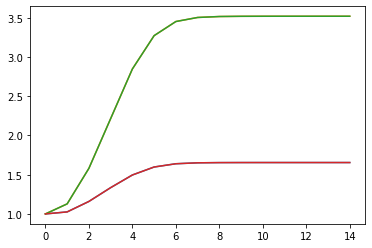

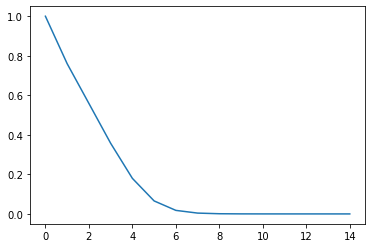

In [453]:
plt.plot(jnp.diag(H1))
plt.plot(jnp.diag(H2))
plt.plot(jnp.diag(G1))
plt.plot(jnp.diag(G2))
plt.show()
plt.plot(Delta)
plt.show()

In [454]:
order_params = [ H1, H2, G1, G2, A,B, Delta, jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros((T,T)), jnp.zeros(T) ]

In [455]:
Hess = action_Hess_manual(order_params, eta, gamma)
Hess_lazy = action_Hess_lazy(order_params, eta)

In [456]:
for i,Hi in enumerate(Hess):
    for j, Hij in enumerate(Hi):
        size_i = np.prod(np.array(order_params[i].shape,dtype='int'))
        size_j = np.prod(np.array(order_params[j].shape,dtype='int'))
        if size_i * size_j != np.prod(np.array(Hij.shape),dtype='int'):
            print(f"i = {i} , j = {j} | predicted size: {size_i * size_j}  , actual size: {np.prod(np.array(Hij.shape))}")
            print((order_params[i].shape, order_params[j].shape))
            print(Hij.shape)

In [457]:
matrix_dim = 10 * T**2 + 2*T
X = np.zeros((matrix_dim, matrix_dim))

# first we have H1,H2,G1,G2 => these blocks are zero
# next we have the off diagonal blocks
ind_x = 0
ind_y = 0
for i, param_i in enumerate(order_params):
    prod_i = np.prod(np.array(param_i.shape,dtype='int'))
    print(f"i = {i}")
    for j, param_j in enumerate(order_params):
        len_i = len(param_i.shape)
        len_j = len(param_j.shape)
        prod_j = np.prod(np.array(param_j.shape,dtype='int'))
        #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
        Hij = Hess[i][j]
        Hji = Hess[j][i]
        if len(Hij.shape) == 4 and len(Hji.shape) == 4:
            print(f"transpose asym err for i={i} j = {j}")
            print( jnp.mean((Hij-Hji.transpose((2,3,0,1)) )**2)/jnp.mean(Hij**2 + 1e-12) )
        X[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
        ind_y += prod_j
    ind_x += prod_i
    ind_y = 0

i = 0
transpose asym err for i=0 j = 0
0.0
transpose asym err for i=0 j = 1
0.0
transpose asym err for i=0 j = 2
0.0
transpose asym err for i=0 j = 3
0.0
transpose asym err for i=0 j = 4
0.0
transpose asym err for i=0 j = 5
0.0
transpose asym err for i=0 j = 7
0.0
transpose asym err for i=0 j = 8
0.0
transpose asym err for i=0 j = 9
0.0
transpose asym err for i=0 j = 10
0.0
i = 1
transpose asym err for i=1 j = 0
0.0
transpose asym err for i=1 j = 1
0.0
transpose asym err for i=1 j = 2
0.0
transpose asym err for i=1 j = 3
0.0
transpose asym err for i=1 j = 4
0.0
transpose asym err for i=1 j = 5
0.0
transpose asym err for i=1 j = 7
0.0
transpose asym err for i=1 j = 8
0.0
transpose asym err for i=1 j = 9
0.0
transpose asym err for i=1 j = 10
0.0
i = 2
transpose asym err for i=2 j = 0
0.0
transpose asym err for i=2 j = 1
0.0
transpose asym err for i=2 j = 2
0.0
transpose asym err for i=2 j = 3
0.0
transpose asym err for i=2 j = 4
0.0
transpose asym err for i=2 j = 5
0.0
transpose asym err

In [458]:
matrix_dim = 10 * T**2 + 2*T
X_lazy = np.zeros((matrix_dim, matrix_dim))

# first we have H1,H2,G1,G2 => these blocks are zero
# next we have the off diagonal blocks
ind_x = 0
ind_y = 0
for i, param_i in enumerate(order_params):
    prod_i = np.prod(np.array(param_i.shape,dtype='int'))
    print(f"i = {i}")
    for j, param_j in enumerate(order_params):
        len_i = len(param_i.shape)
        len_j = len(param_j.shape)
        prod_j = np.prod(np.array(param_j.shape,dtype='int'))
        #print(f"len i: {len_i} | len j {len_j} | prod i: {prod_i} | prod j {prod_j}")
        Hij = Hess_lazy[i][j]
        Hji = Hess_lazy[j][i]
        X_lazy[ind_x:ind_x+prod_i,ind_y:ind_y+prod_j] = Hij.reshape((prod_i,prod_j))
        ind_y += prod_j
    ind_x += prod_i
    ind_y = 0

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11


In [459]:
print(jnp.mean((X.T - X)**2 ) / jnp.mean(X**2))
print(jnp.mean((X_lazy.T - X_lazy)**2 ) / jnp.mean(X_lazy**2))

0.00021133262
0.0


In [460]:
prop = -jnp.linalg.inv(X)
prop_lazy = -jnp.linalg.inv(X_lazy + 1e-10 * jnp.eye(matrix_dim))

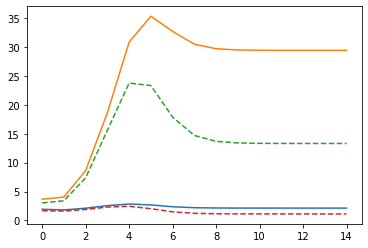

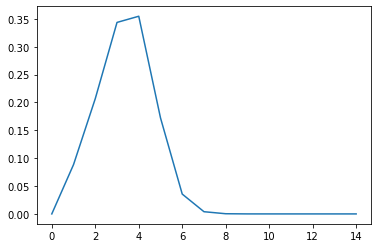

In [461]:
Sigma_H1 = prop[:T**2,:T**2].reshape((T,T,T,T))
Sigma_H2 = prop[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))
Sigma_G1 = prop[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
Sigma_G2 = prop[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))

Sigma_Delta = prop[6*T**2:6*T**2+T,6*T**2:6*T**2+T].reshape((T,T))
plt.plot(jnp.einsum('iiii->i', Sigma_H1))
plt.plot(jnp.einsum('iiii->i', Sigma_H2))
plt.plot(jnp.einsum('iiii->i', Sigma_G1), '--')
plt.plot(jnp.einsum('iiii->i', Sigma_G2), '--')
#plt.ylim([0,10.0])
plt.show()

plt.plot(jnp.diag(Sigma_Delta))
plt.show()


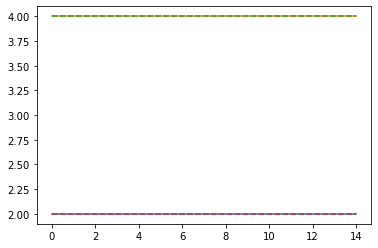

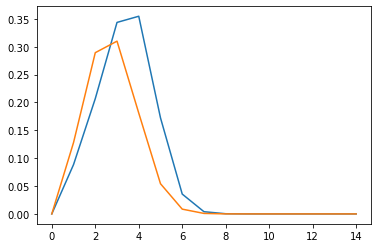

[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  8.84497613e-02  1.24658376e-01  1.48471236e-01
   1.50065035e-01  1.13767587e-01  5.91370761e-02  2.23593712e-02
   7.02198502e-03  1.99841615e-03  5.37914224e-04  1.39162803e-04
   3.59491896e-05  9.21663377e-06  1.70765497e-06]
 [-0.00000000e+00  1.32838950e-01  2.06772536e-01  2.68288970e-01
   2.86140472e-01  2.22899556e-01  1.17244408e-01  4.45512980e-02
   1.40244514e-02  3.99647234e-03  1.07662624e-03  2.78677442e-04
   7.20462049e-05  1.84880973e-05  3.42715748e-06]
 [-0.00000000e+00  1.46785840e-01  2.49716252e-01  3.43502820e-01
   3.79299879e-01  3.00276428e-01  1.59011036e-01  6.05902001e-02
   1.90982278e-02  5.44620864e-03  1.46784680e-03  3.80051235e-04
   9.82982820e-05  2.52401733e-05  4.67972541e-06]
 [-0

In [462]:
Sigma_H1 = prop_lazy[:T**2,:T**2].reshape((T,T,T,T))
Sigma_H2 = prop_lazy[T**2:2*T**2,T**2:2*T**2].reshape((T,T,T,T))
Sigma_G1 = prop_lazy[2*T**2:3*T**2,2*T**2:3*T**2].reshape((T,T,T,T))
Sigma_G2 = prop_lazy[3*T**2:4*T**2,3*T**2:4*T**2].reshape((T,T,T,T))

Sigma_Delta_lazy = prop_lazy[6*T**2:6*T**2+T,6*T**2:6*T**2+T].reshape((T,T))
plt.plot(jnp.einsum('iiii->i', Sigma_H1))
plt.plot(jnp.einsum('iiii->i', Sigma_H2))
plt.plot(jnp.einsum('iiii->i', Sigma_G1), '--')
plt.plot(jnp.einsum('iiii->i', Sigma_G2), '--')
#plt.ylim([0,10.0])
plt.show()

plt.plot(jnp.diag(Sigma_Delta))
plt.plot(jnp.diag(Sigma_Delta_lazy))
plt.show()
print(Sigma_Delta)